In [110]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import catboost
import optuna

import eli5
from eli5.sklearn import PermutationImportance

In [111]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/Upstage_ML_Competition01/data/train.csv'
test_path  = '/data/ephemeral/home/Upstage_ML_Competition01/data/test.csv'
codebook_path = '/data/ephemeral/home/Upstage_ML_Competition01/data/codebook.csv' # 코드북의 경로
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
codebook = pd.read_csv(codebook_path) # 코드북 경로를 통해 코드북을 불러옴

## Data Preprocessing

In [112]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
train['is_test'] = 0
test['is_test'] = 1
concat = pd.concat([train, test])     # 하나의 데이터로 만들어줍니다.

In [113]:
# # codebook에 있는 변수명들로 변경해줍시다.
# variables = codebook.set_index('한글 변수명').to_dict()['영문 변수명'] # 코드북에 있는 한글 변수명 column을 키로 영문 변수명 column을 value로 한 딕셔너리타입 변수 생성
# concat.rename(columns=variables, inplace=True) # column의 이름 변경

In [114]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [115]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat['구'] = concat['시군구'].map(lambda x : x.split()[1])
concat['동'] = concat['시군구'].map(lambda x : x.split()[2])
# del concat['시군구']

concat['계약년'] = concat['계약년월'].astype('str').map(lambda x : x[:4])
concat['계약월'] = concat['계약년월'].astype('str').map(lambda x : x[4:])
# del concat['계약년월']

In [116]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '구', '동', '계약년', '계약월'],
      dtype='object')

In [117]:
concat = concat.rename(columns={'전용면적(㎡)':'전용면적',
                                'k-단지분류(아파트,주상복합등등)' : '단지분류',
                                'k-전화번호' : '전화번호', 
                                'k-팩스번호' : '팩스번호',
                                'k-세대타입(분양형태)' : '분양형태',
                                'k-관리방식' : '관리방식',
                                'k-복도유형' : '복도유형',
                                'k-난방방식' : '난방방식',
                                'k-전체동수' : '전체동수',
                                'k-전체세대수' : '전체세대수',
                                'k-건설사(시공사)' : '시공사',
                                'k-시행사' : '시행사', 
                                'k-사용검사일-사용승인일' : '사용검사일-사용승인일',
                                'k-연면적' : '연면적',
                                'k-주거전용면적' : '주거전용면적',
                                'k-관리비부과면적' : '관리비부과면적',
                                'k-전용면적별세대현황(60㎡이하)' : '전용면적별세대현황(60㎡이하)',
                                'k-전용면적별세대현황(60㎡~85㎡이하)' : '전용면적별세대현황(60㎡~85㎡이하)',
                                'k-85㎡~135㎡이하' : '전용면적별세대현황(85㎡~135㎡이하)',
                                'k-135㎡초과' : '전용면적별세대현황(135㎡초과)',
                                'k-홈페이지' : '홈페이지',
                                'k-등록일자' : '등록일자',
                                'k-수정일자' : '수정일자',
                                '기타/의무/임대/임의=1/2/3/4' : '권리유형',
                                'target' : '집값(target)',
                                'is_test' : '테스트셋여부'
                                })

In [118]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지분류', '전화번호', '팩스번호',
       '단지소개기존clob', '분양형태', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '시공사',
       '시행사', '사용검사일-사용승인일', '연면적', '주거전용면적', '관리비부과면적', '전용면적별세대현황(60㎡이하)',
       '전용면적별세대현황(60㎡~85㎡이하)', '전용면적별세대현황(85㎡~135㎡이하)', '전용면적별세대현황(135㎡초과)',
       '홈페이지', '등록일자', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '권리유형', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', '집값(target)', '테스트셋여부', '구', '동', '계약년', '계약월'],
      dtype='object')

In [119]:
using_list = ['구', '동','계약년', '계약월', '아파트명', '전용면적', '계약일', '층', '건축년도',
       '도로명', '거래유형', '단지분류', '분양형태', '전체동수', '전체세대수', '시공사',
       '시행사', '연면적', '주거전용면적', '관리비부과면적', '전용면적별세대현황(60㎡이하)',
       '전용면적별세대현황(60㎡~85㎡이하)', '전용면적별세대현황(85㎡~135㎡이하)', '전용면적별세대현황(135㎡초과)',
       '건축면적', '주차대수', '권리유형', '단지신청일', '집값(target)', '테스트셋여부']

In [120]:
using_concat = concat[using_list]
using_concat

구    동   계약년 계약월      아파트명    전용면적  계약일   층  건축년도        도로명  ...  \
0     강남구  개포동  2017  12    개포6차우성   79.97    8   3  1987      언주로 3  ...   
1     강남구  개포동  2017  12    개포6차우성   79.97   22   4  1987      언주로 3  ...   
2     강남구  개포동  2017  12    개포6차우성   54.98   28   5  1987      언주로 3  ...   
3     강남구  개포동  2018  01    개포6차우성   79.97    3   4  1987      언주로 3  ...   
4     강남구  개포동  2018  01    개포6차우성   79.97    8   2  1987      언주로 3  ...   
...   ...  ...   ...  ..       ...     ...  ...  ..   ...        ...  ...   
9267  중랑구  신내동  2023  07  신내우디안1단지   84.65   19  13  2014  신내역로1길 85  ...   
9268  중랑구  신내동  2023  07  신내우디안1단지   84.62   25  12  2014  신내역로1길 85  ...   
9269  중랑구  신내동  2023  08  신내우디안1단지  101.65   27  12  2014  신내역로1길 85  ...   
9270  중랑구  신내동  2023  09  신내우디안1단지   84.94    2  18  2014  신내역로1길 85  ...   
9271  중랑구  신내동  2023  09  신내우디안1단지   84.65    4  13  2014  신내역로1길 85  ...   

     전용면적별세대현황(60㎡이하) 전용면적별세대현황(60㎡~85㎡이하) 전용면적별세대현황(85㎡~135㎡이하)  \
0                20.0                250.0                   0.0   
1                20.0                250.0                   0.0   
2                20.0                250.0                   0.0   
3                20.0                250.0                   0.0   
4                20.0                250.0                   0.0   
...               ...                  ...                   ...   
9267            808.0                504.0                  90.0   
9268            808.0                504.0                  90.0   
9269            808.0                504.0                  90.0   
9270            808.0                504.0                  90.0   
9271            808.0                504.0                  90.0   

      전용면적별세대현황(135㎡초과)     건축면적    주차대수 권리유형                  단지신청일  \
0                   NaN   4858.0   262.0   임의  2022-11-17 10:19:06.0   
1                   NaN   4858.0   262.0   임의  2022-11-17 10:19:06.0   
2                   NaN   4858.0   262.0   임의  2022-11-17 10:19:06.0   
3                   NaN   4858.0   262.0   임의  2022-11-17 10:19:06.0   
4                   NaN   4858.0   262.0   임의  2022-11-17 10:19:06.0   
...                 ...      ...     ...  ...                    ...   
9267                NaN  14171.0  1568.0   의무  2014-09-01 13:05:03.0   
9268                NaN  14171.0  1568.0   의무  2014-09-01 13:05:03.0   
9269                NaN  14171.0  1568.0   의무  2014-09-01 13:05:03.0   
9270                NaN  14171.0  1568.0   의무  2014-09-01 13:05:03.0   
9271                NaN  14171.0  1568.0   의무  2014-09-01 13:05:03.0   

      집값(target)  테스트셋여부  
0       124000.0       0  
1       123500.0       0  
2        91500.0       0  
3       130000.0       0  
4       117000.0       0  
...          ...     ...  
9267         NaN       1  
9268         NaN       1  
9269         NaN       1  
9270         NaN       1  
9271         NaN       1  

[1128094 rows x 30 columns]

In [121]:
using_concat[using_concat["층"]==-4]

구    동   계약년 계약월             아파트명    전용면적  계약일  층  건축년도         도로명  \
133319  은평구  진관동  2012  01  우물골2단지두산위브BL2-7  134.46   11 -4  2010  진관2로 57-37   
133322  은평구  진관동  2012  02  우물골2단지두산위브BL2-7  134.46    3 -4  2010  진관2로 57-37   
133323  은평구  진관동  2012  02  우물골2단지두산위브BL2-7  134.46   17 -4  2010  진관2로 57-37   
755327  은평구  진관동  2015  03  우물골2단지두산위브BL2-7  134.46   31 -4  2010  진관2로 57-37   

        ... 전용면적별세대현황(60㎡이하) 전용면적별세대현황(60㎡~85㎡이하) 전용면적별세대현황(85㎡~135㎡이하)  \
133319  ...              NaN                  NaN                   NaN   
133322  ...              NaN                  NaN                   NaN   
133323  ...              NaN                  NaN                   NaN   
755327  ...              NaN                  NaN                   NaN   

        전용면적별세대현황(135㎡초과)  건축면적 주차대수 권리유형  단지신청일  집값(target)  테스트셋여부  
133319                NaN   NaN  NaN  NaN    NaN     62600.0       0  
133322                NaN   NaN  NaN  NaN    NaN     62600.0       0  
133323                NaN   NaN  NaN  NaN    NaN     65050.0       0  
755327                NaN   NaN  NaN  NaN    NaN     55567.0       0  

[4 rows x 30 columns]

In [122]:
def floor_to_categorical(floor) :
    if floor > 30:
        return "고층"
    elif floor >= 15 and floor <= 30:
        return "로열층"
    elif floor >= 0 and floor < 15:
        return "저층"
    elif floor < 0:
        return "지하"
    else :
        return np.nan

In [123]:
using_concat["층높이"] = using_concat["층"].apply(floor_to_categorical)

In [124]:
concat[concat["테스트셋여부"]==0][["아파트명", "전체세대수", '전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '전용면적별세대현황(85㎡~135㎡이하)', '전용면적별세대현황(135㎡초과)', "집값(target)"]].head(20)


아파트명  전체세대수  전용면적별세대현황(60㎡이하)  전용면적별세대현황(60㎡~85㎡이하)  \
0   개포6차우성  270.0              20.0                 250.0   
1   개포6차우성  270.0              20.0                 250.0   
2   개포6차우성  270.0              20.0                 250.0   
3   개포6차우성  270.0              20.0                 250.0   
4   개포6차우성  270.0              20.0                 250.0   
5   개포6차우성  270.0              20.0                 250.0   
6   개포6차우성  270.0              20.0                 250.0   
7   개포6차우성  270.0              20.0                 250.0   
8   개포6차우성  270.0              20.0                 250.0   
9   개포6차우성  270.0              20.0                 250.0   
10  개포6차우성  270.0              20.0                 250.0   
11  개포6차우성  270.0              20.0                 250.0   
12  개포우성3차  405.0               0.0                   0.0   
13  개포우성3차  405.0               0.0                   0.0   
14  개포우성3차  405.0               0.0                   0.0   
15  개포우성3차  405.0               0.0                   0.0   
16  개포우성3차  405.0               0.0                   0.0   
17  개포우성3차  405.0               0.0                   0.0   
18  개포우성3차  405.0               0.0                   0.0   
19  개포우성3차  405.0               0.0                   0.0   

    전용면적별세대현황(85㎡~135㎡이하)  전용면적별세대현황(135㎡초과)  집값(target)  
0                     0.0                NaN    124000.0  
1                     0.0                NaN    123500.0  
2                     0.0                NaN     91500.0  
3                     0.0                NaN    130000.0  
4                     0.0                NaN    117000.0  
5                     0.0                NaN    130000.0  
6                     0.0                NaN    139500.0  
7                     0.0                NaN    107500.0  
8                     0.0                NaN    145000.0  
9                     0.0                NaN    112000.0  
10                    0.0                NaN    160000.0  
11                    0.0                NaN    160000.0  
12                  285.0                NaN    152000.0  
13                  285.0                NaN    182000.0  
14                  285.0                NaN    170000.0  
15                  285.0                NaN    185000.0  
16                  285.0                NaN    175000.0  
17                  285.0                NaN    210000.0  
18                  285.0                NaN    225000.0  
19                  285.0                NaN    160000.0

In [125]:
using_concat[(using_concat["테스트셋여부"]==0) & (using_concat["전체세대수"].isna()==True)][["아파트명", "전체세대수", '전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '전용면적별세대현황(85㎡~135㎡이하)', '전용면적별세대현황(135㎡초과)', "집값(target)"]].head(30)

아파트명  전체세대수  전용면적별세대현황(60㎡이하)  전용면적별세대현황(60㎡~85㎡이하)  \
975   개포주공4단지    NaN               NaN                   NaN   
976   개포주공4단지    NaN               NaN                   NaN   
977   개포주공4단지    NaN               NaN                   NaN   
978   개포주공4단지    NaN               NaN                   NaN   
979   개포주공4단지    NaN               NaN                   NaN   
980   개포주공4단지    NaN               NaN                   NaN   
981   개포주공4단지    NaN               NaN                   NaN   
982   개포주공4단지    NaN               NaN                   NaN   
983   개포주공4단지    NaN               NaN                   NaN   
984   개포주공4단지    NaN               NaN                   NaN   
985   개포주공4단지    NaN               NaN                   NaN   
986   개포주공7단지    NaN               NaN                   NaN   
987   개포주공7단지    NaN               NaN                   NaN   
988   개포주공7단지    NaN               NaN                   NaN   
989   개포주공7단지    NaN               NaN                   NaN   
990   개포주공7단지    NaN               NaN                   NaN   
991   개포주공7단지    NaN               NaN                   NaN   
992   개포주공7단지    NaN               NaN                   NaN   
993   개포주공7단지    NaN               NaN                   NaN   
994   개포주공7단지    NaN               NaN                   NaN   
995   개포주공7단지    NaN               NaN                   NaN   
996   개포주공7단지    NaN               NaN                   NaN   
997   개포주공7단지    NaN               NaN                   NaN   
998   개포주공7단지    NaN               NaN                   NaN   
999   개포주공7단지    NaN               NaN                   NaN   
1000  개포주공7단지    NaN               NaN                   NaN   
1001  개포주공7단지    NaN               NaN                   NaN   
1002  개포주공7단지    NaN               NaN                   NaN   
1003  개포주공7단지    NaN               NaN                   NaN   
1004  개포주공7단지    NaN               NaN                   NaN   

      전용면적별세대현황(85㎡~135㎡이하)  전용면적별세대현황(135㎡초과)  집값(target)  
975                     NaN                NaN    134000.0  
976                     NaN                NaN    158000.0  
977                     NaN                NaN    155000.0  
978                     NaN                NaN    132000.0  
979                     NaN                NaN    154000.0  
980                     NaN                NaN    150000.0  
981                     NaN                NaN    150000.0  
982                     NaN                NaN    145000.0  
983                     NaN                NaN    189500.0  
984                     NaN                NaN    190000.0  
985                     NaN                NaN    157000.0  
986                     NaN                NaN    140000.0  
987                     NaN                NaN    138000.0  
988                     NaN                NaN    128000.0  
989                     NaN                NaN    138000.0  
990                     NaN                NaN    130000.0  
991                     NaN                NaN    119000.0  
992                     NaN                NaN    106800.0  
993                     NaN                NaN    104000.0  
994                     NaN                NaN    130200.0  
995                     NaN                NaN    108500.0  
996                     NaN                NaN    136000.0  
997                     NaN                NaN    130000.0  
998                     NaN                NaN    150000.0  
999                     NaN                NaN    110000.0  
1000                    NaN                NaN    142000.0  
1001                    NaN                NaN    146000.0  
1002                    NaN                NaN    141000.0  
1003                    NaN                NaN    145000.0  
1004                    NaN                NaN    140000.0

In [126]:
len(using_concat[(using_concat["테스트셋여부"]==0) & (using_concat["전체세대수"].isna()==True)]["아파트명"].unique())

5856

In [127]:
using_concat.sort_values(by="전용면적별세대현황(135㎡초과)")

구    동   계약년 계약월      아파트명    전용면적  계약일   층  건축년도        도로명  ...  \
93602   중랑구   묵동  2017  10      묵동자이  111.32   20  28  2010  숙선옹주로 6-9  ...   
540574  중랑구   묵동  2017  06      묵동자이  114.43    6  19  2010  숙선옹주로 6-9  ...   
540573  중랑구   묵동  2017  05      묵동자이  111.32   30  12  2010  숙선옹주로 6-9  ...   
540572  중랑구   묵동  2017  03      묵동자이  112.23   18  29  2010  숙선옹주로 6-9  ...   
540571  중랑구   묵동  2016  12      묵동자이  114.43   30  18  2010  숙선옹주로 6-9  ...   
...     ...  ...   ...  ..       ...     ...  ...  ..   ...        ...  ...   
9267    중랑구  신내동  2023  07  신내우디안1단지   84.65   19  13  2014  신내역로1길 85  ...   
9268    중랑구  신내동  2023  07  신내우디안1단지   84.62   25  12  2014  신내역로1길 85  ...   
9269    중랑구  신내동  2023  08  신내우디안1단지  101.65   27  12  2014  신내역로1길 85  ...   
9270    중랑구  신내동  2023  09  신내우디안1단지   84.94    2  18  2014  신내역로1길 85  ...   
9271    중랑구  신내동  2023  09  신내우디안1단지   84.65    4  13  2014  신내역로1길 85  ...   

       전용면적별세대현황(60㎡~85㎡이하) 전용면적별세대현황(85㎡~135㎡이하) 전용면적별세대현황(135㎡초과)     건축면적  \
93602                   0.0                 204.0              70.0   4209.7   
540574                  0.0                 204.0              70.0   4209.7   
540573                  0.0                 204.0              70.0   4209.7   
540572                  0.0                 204.0              70.0   4209.7   
540571                  0.0                 204.0              70.0   4209.7   
...                     ...                   ...               ...      ...   
9267                  504.0                  90.0               NaN  14171.0   
9268                  504.0                  90.0               NaN  14171.0   
9269                  504.0                  90.0               NaN  14171.0   
9270                  504.0                  90.0               NaN  14171.0   
9271                  504.0                  90.0               NaN  14171.0   

          주차대수 권리유형                  단지신청일  집값(target)  테스트셋여부  층높이  
93602    461.0   의무  2013-03-07 09:46:43.0     64000.0       0  로열층  
540574   461.0   의무  2013-03-07 09:46:43.0     62000.0       0  로열층  
540573   461.0   의무  2013-03-07 09:46:43.0     57250.0       0   저층  
540572   461.0   의무  2013-03-07 09:46:43.0     57000.0       0  로열층  
540571   461.0   의무  2013-03-07 09:46:43.0     59000.0       0  로열층  
...        ...  ...                    ...         ...     ...  ...  
9267    1568.0   의무  2014-09-01 13:05:03.0         NaN       1   저층  
9268    1568.0   의무  2014-09-01 13:05:03.0         NaN       1   저층  
9269    1568.0   의무  2014-09-01 13:05:03.0         NaN       1   저층  
9270    1568.0   의무  2014-09-01 13:05:03.0         NaN       1  로열층  
9271    1568.0   의무  2014-09-01 13:05:03.0         NaN       1   저층  

[1128094 rows x 31 columns]

In [128]:
using_concat.columns

Index(['구', '동', '계약년', '계약월', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       '거래유형', '단지분류', '분양형태', '전체동수', '전체세대수', '시공사', '시행사', '연면적', '주거전용면적',
       '관리비부과면적', '전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)',
       '전용면적별세대현황(85㎡~135㎡이하)', '전용면적별세대현황(135㎡초과)', '건축면적', '주차대수', '권리유형',
       '단지신청일', '집값(target)', '테스트셋여부', '층높이'],
      dtype='object')

In [131]:
visual = concat
visual["계약년월"] = visual["계약년월"].astype("Int64")
visual = visual.sort_values(by=["계약년월"])
visual["계약년월"] = visual["계약년월"].astype(str)

In [133]:
concat["계약년월"] = concat["계약년월"].astype(str)
concat["계약년"] = concat["계약년"].astype(str)
concat["계약월"] = concat["계약월"].astype(str)

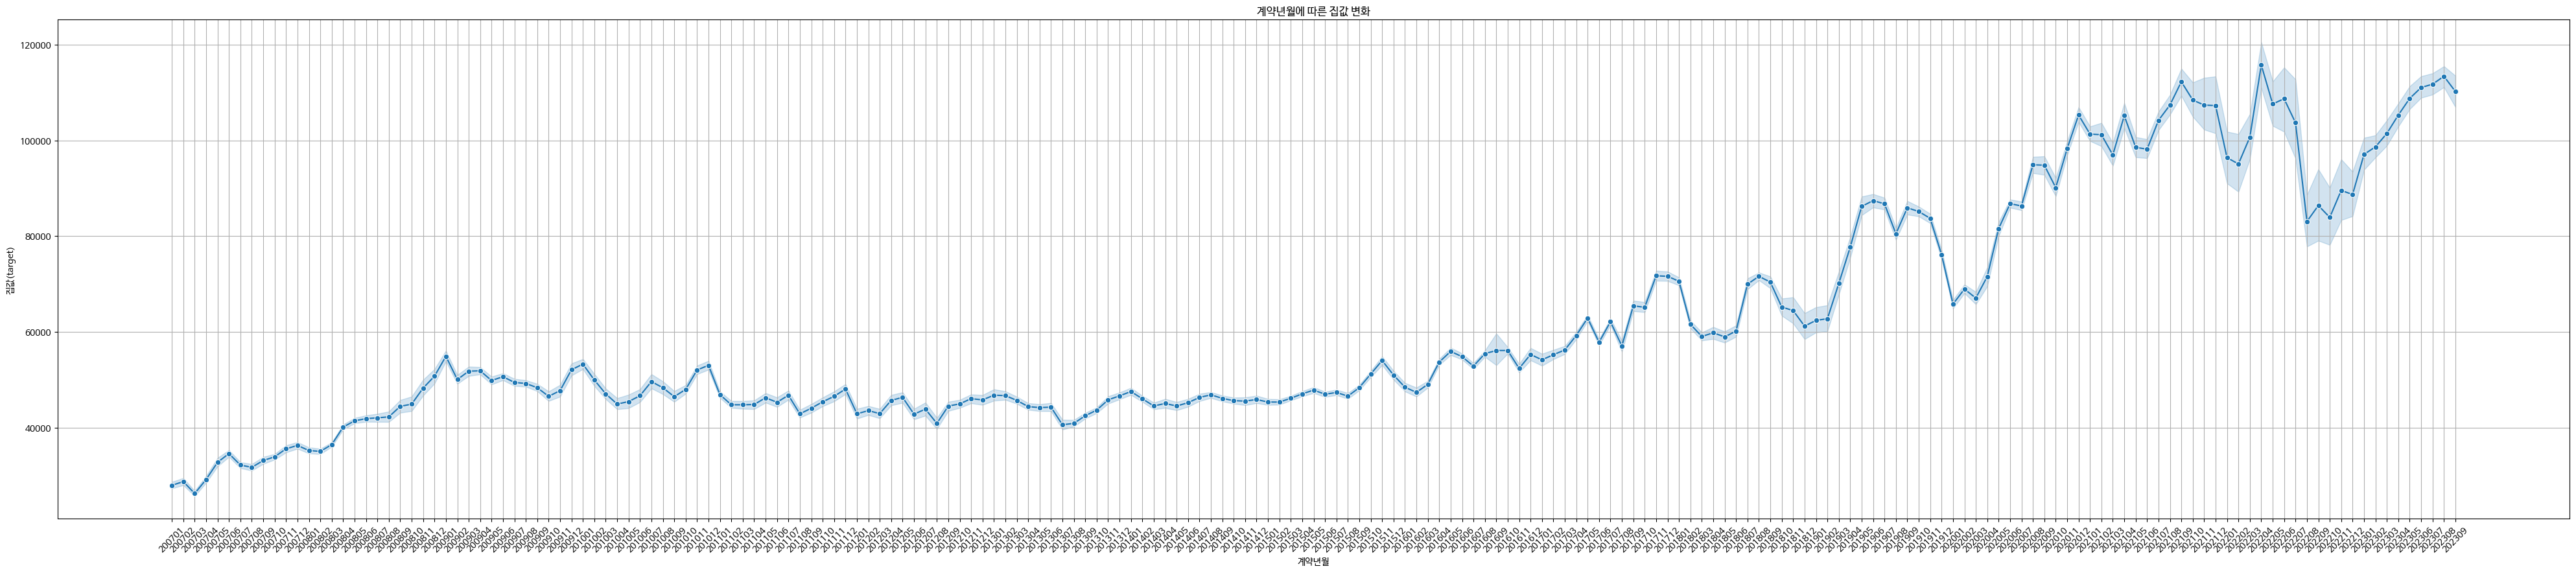

In [134]:
plt.figure(figsize=(50, 10))
plt.title("계약년월에 따른 집값 변화")
plt.xticks(rotation=45)
plt.grid(True)
sns.lineplot(data=visual, x="계약년월", y= "집값(target)", marker='o')
plt.show()

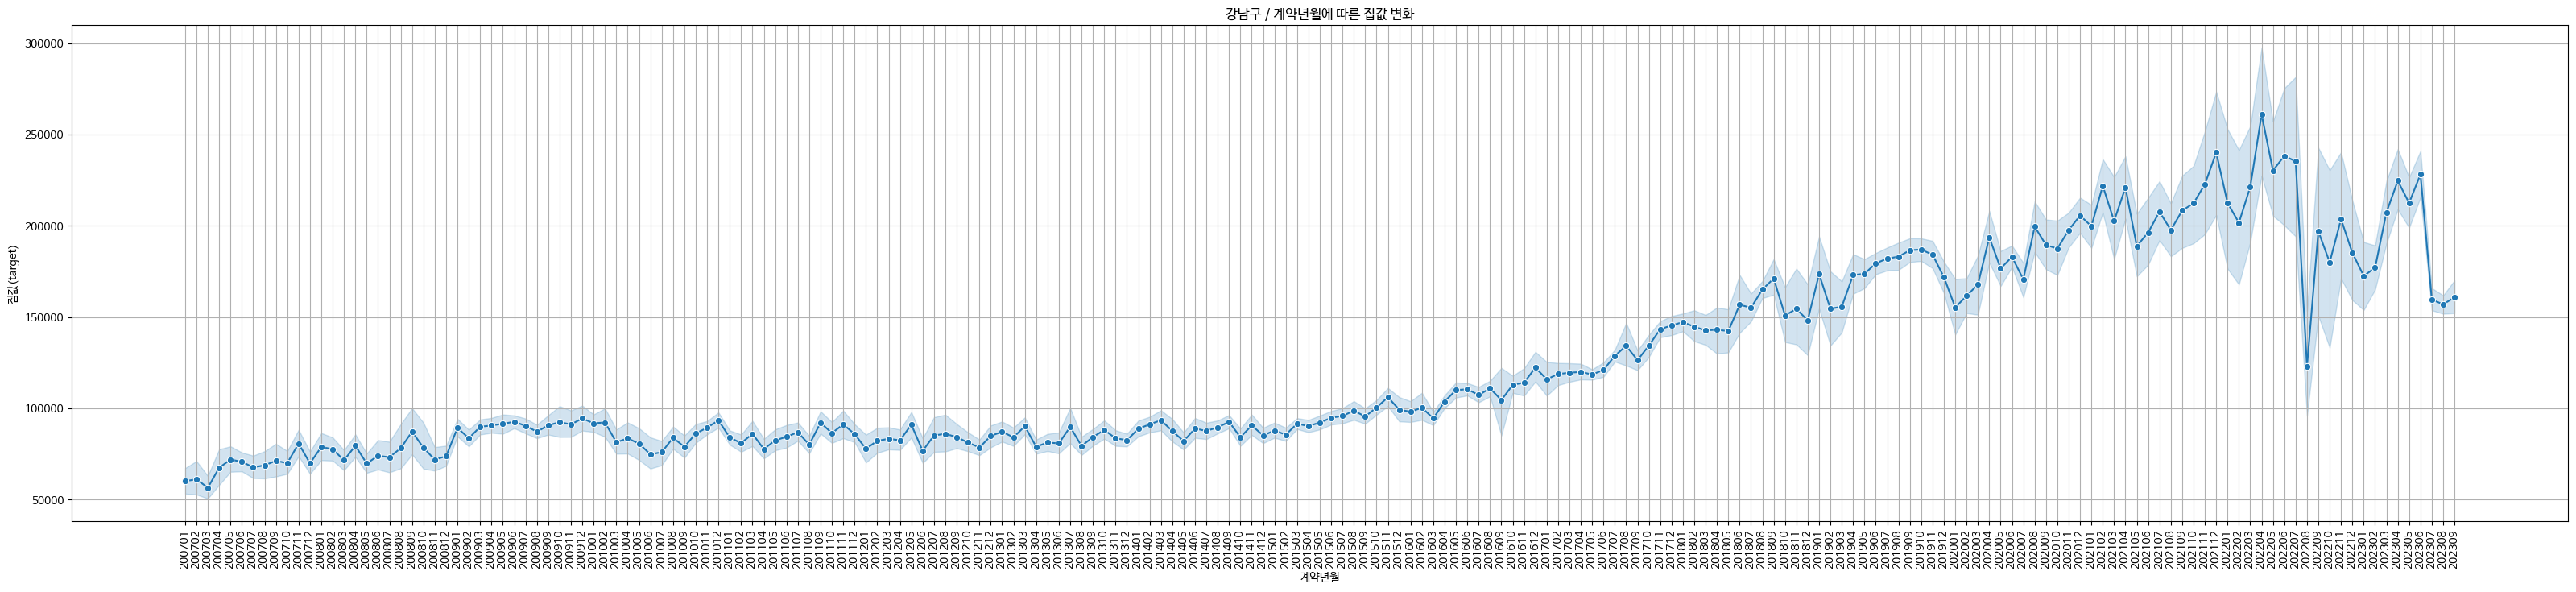

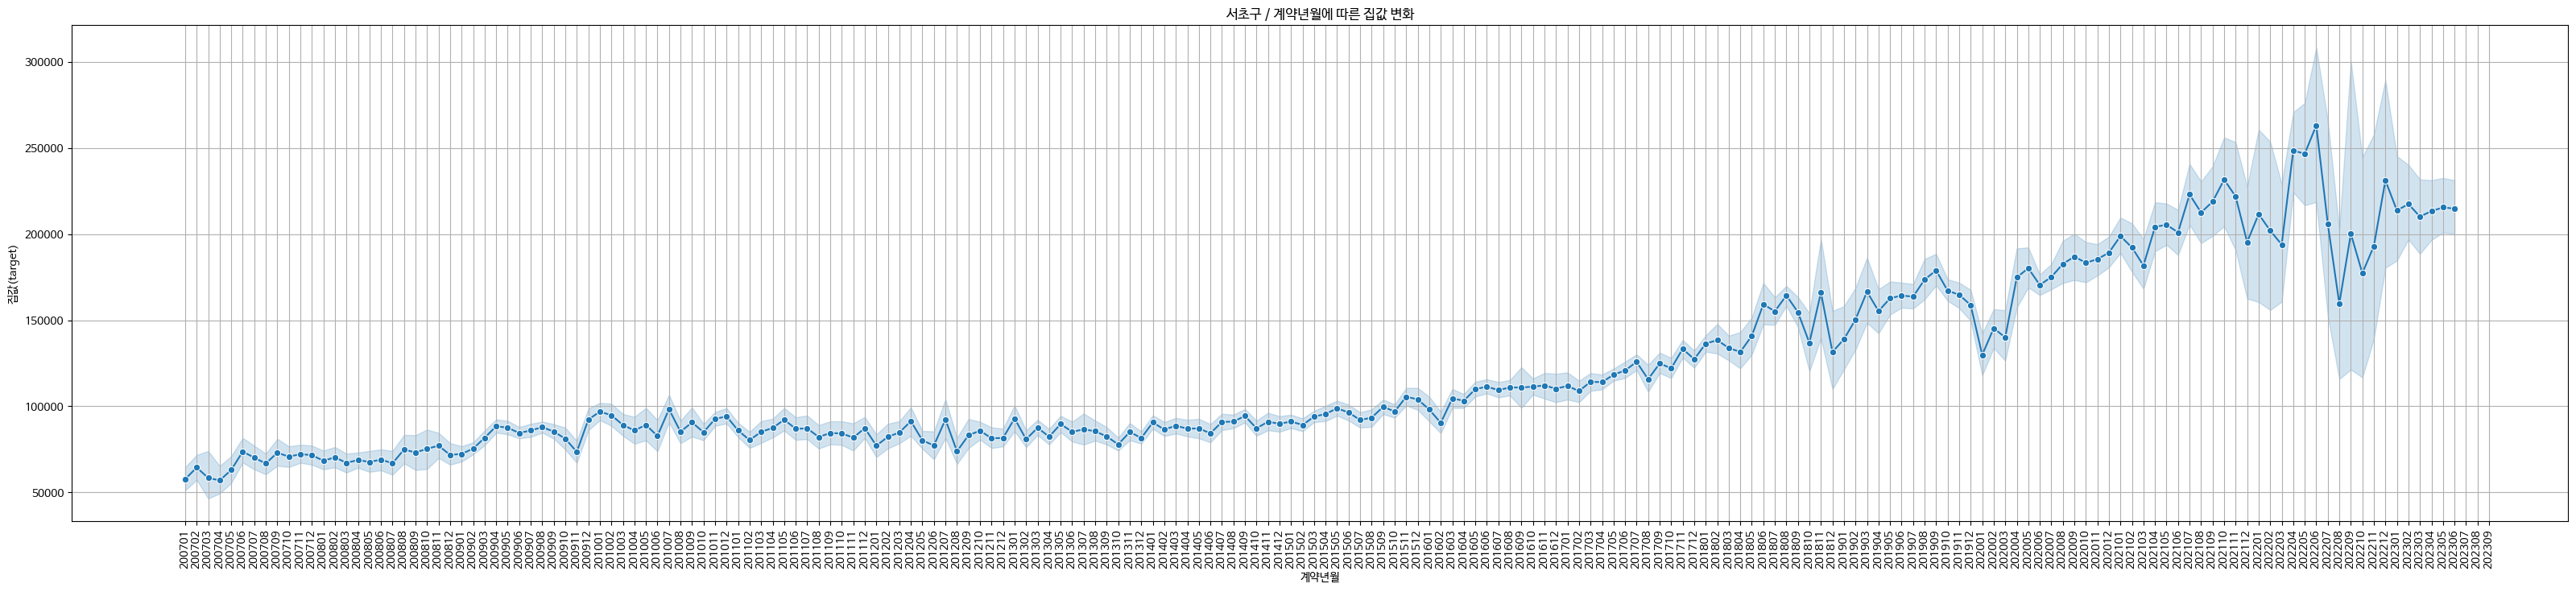

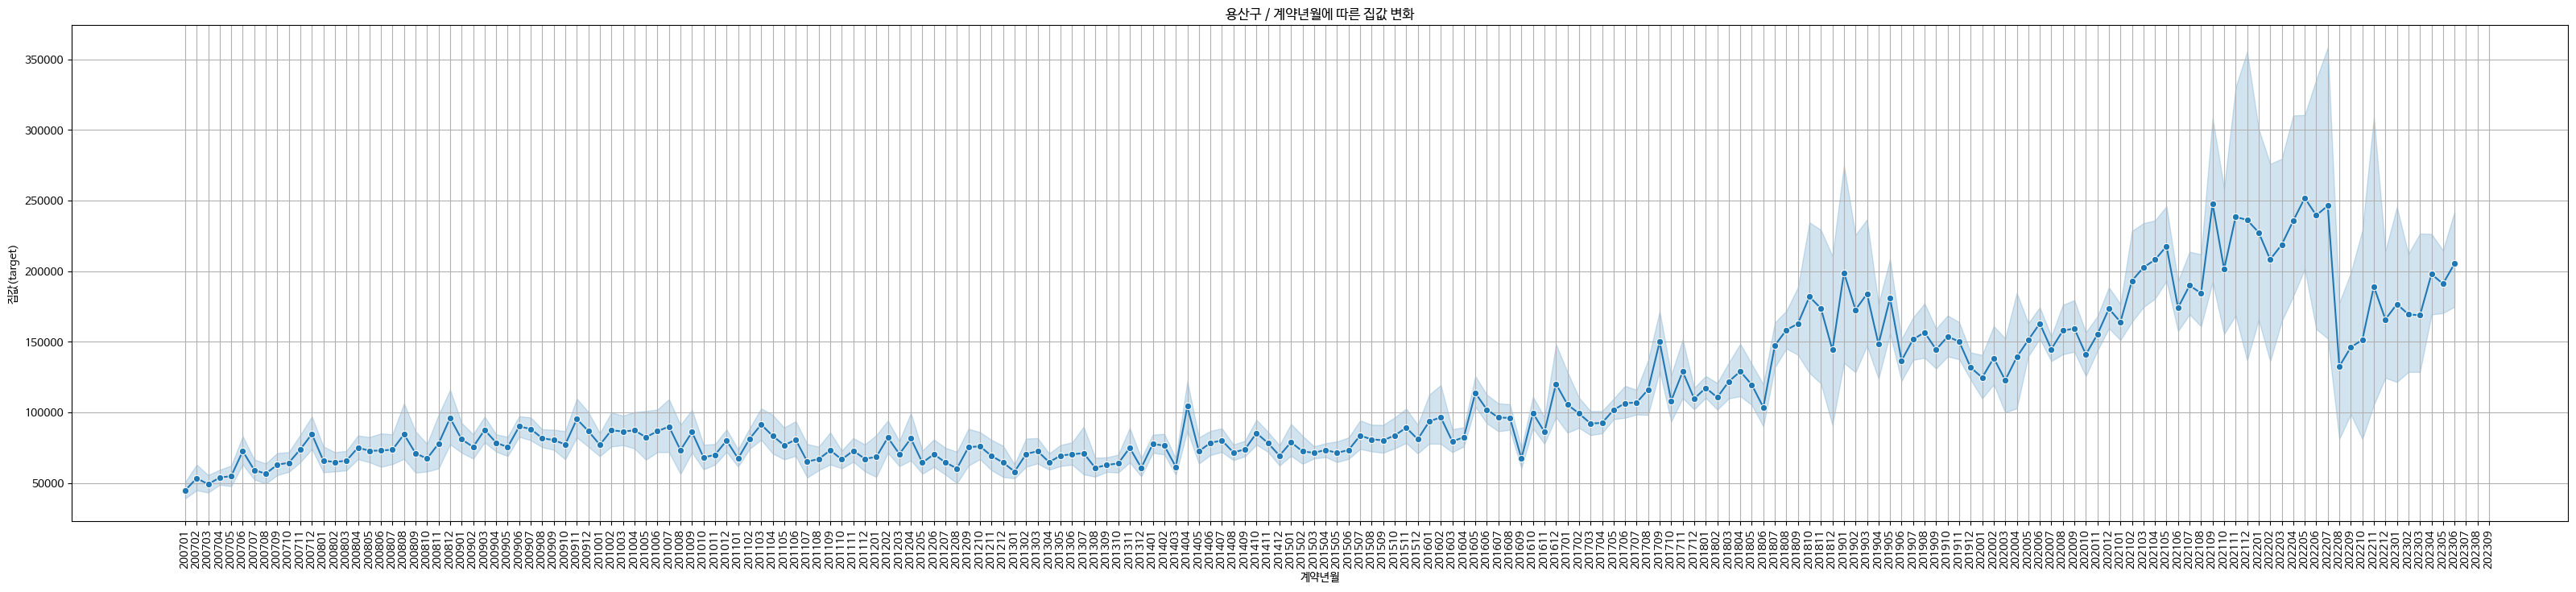

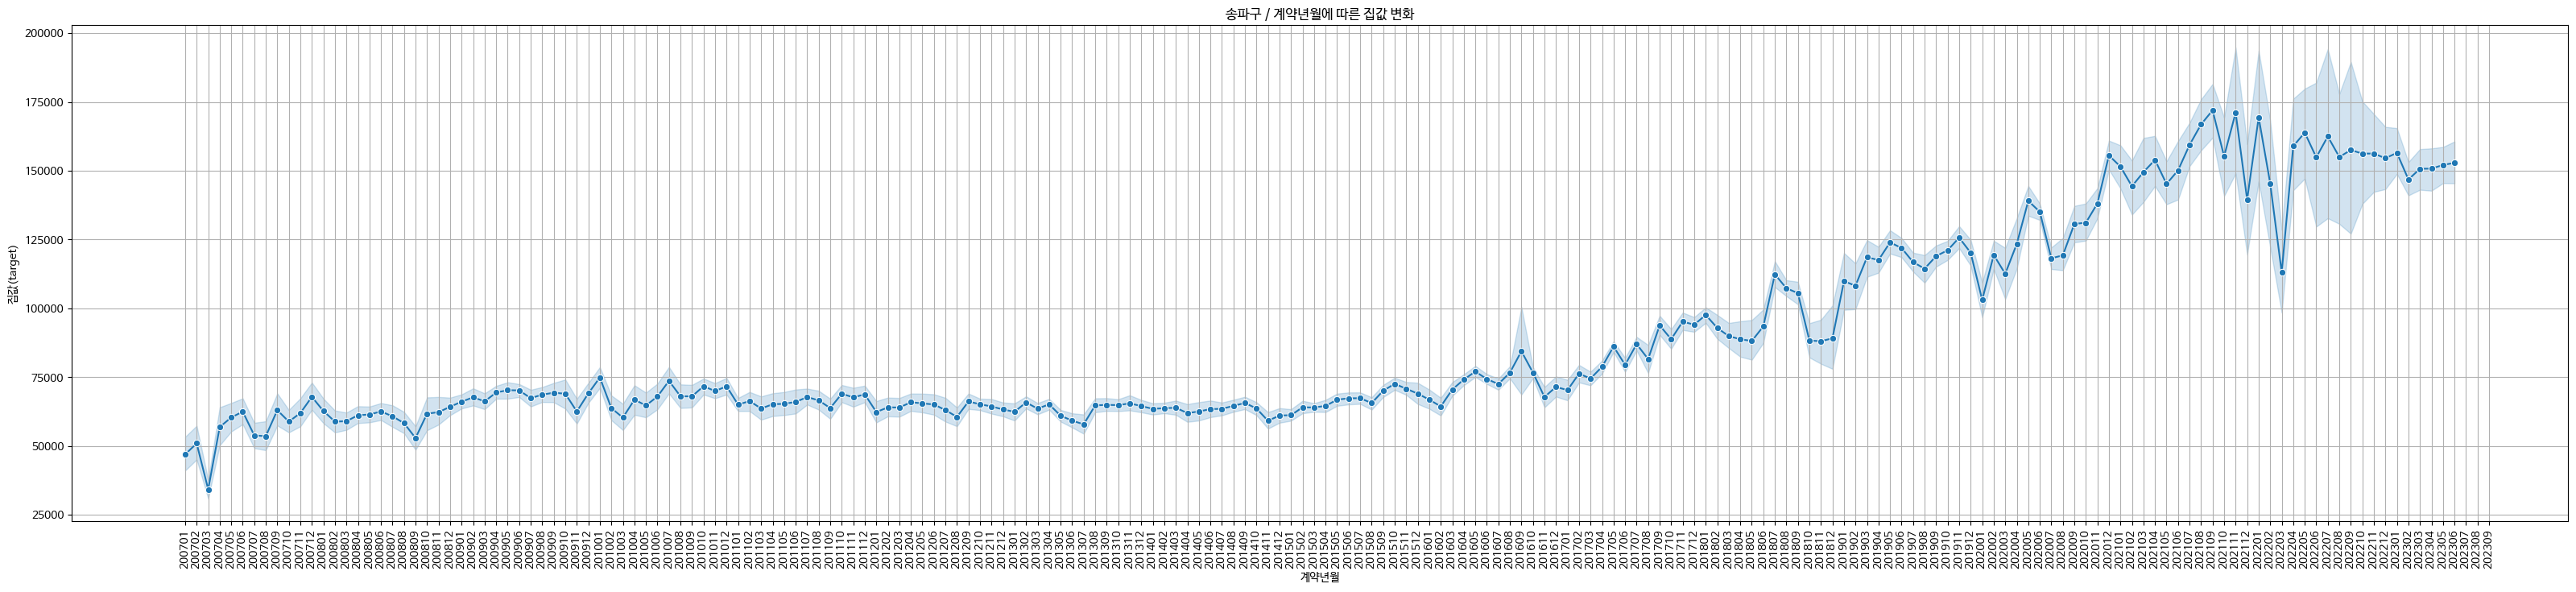

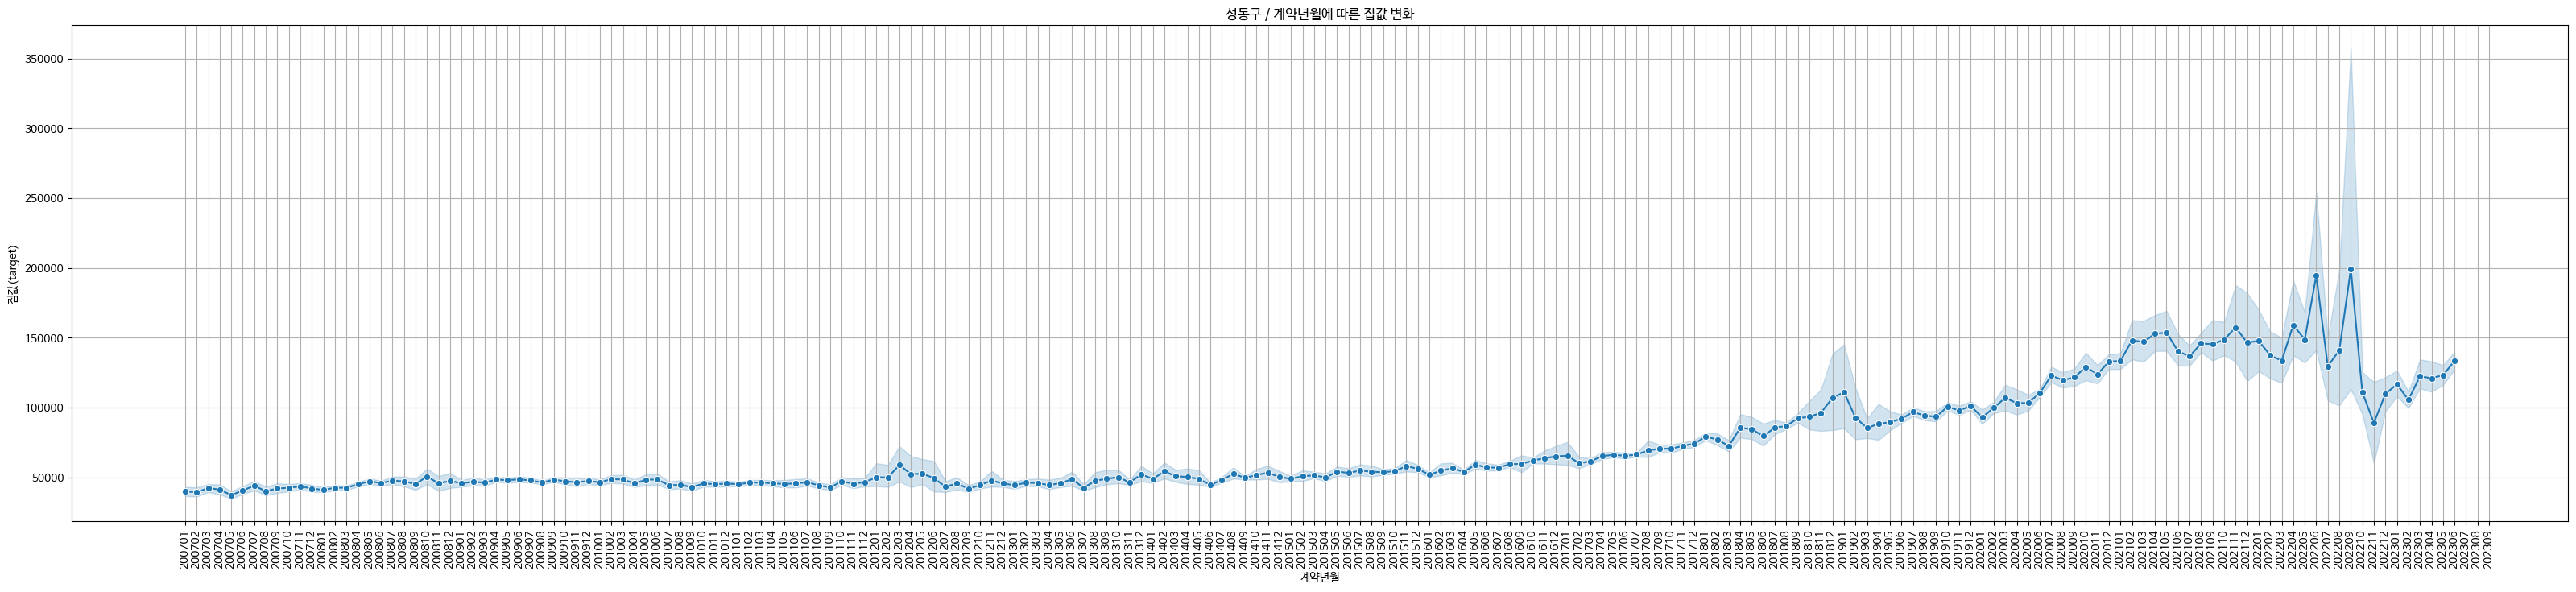

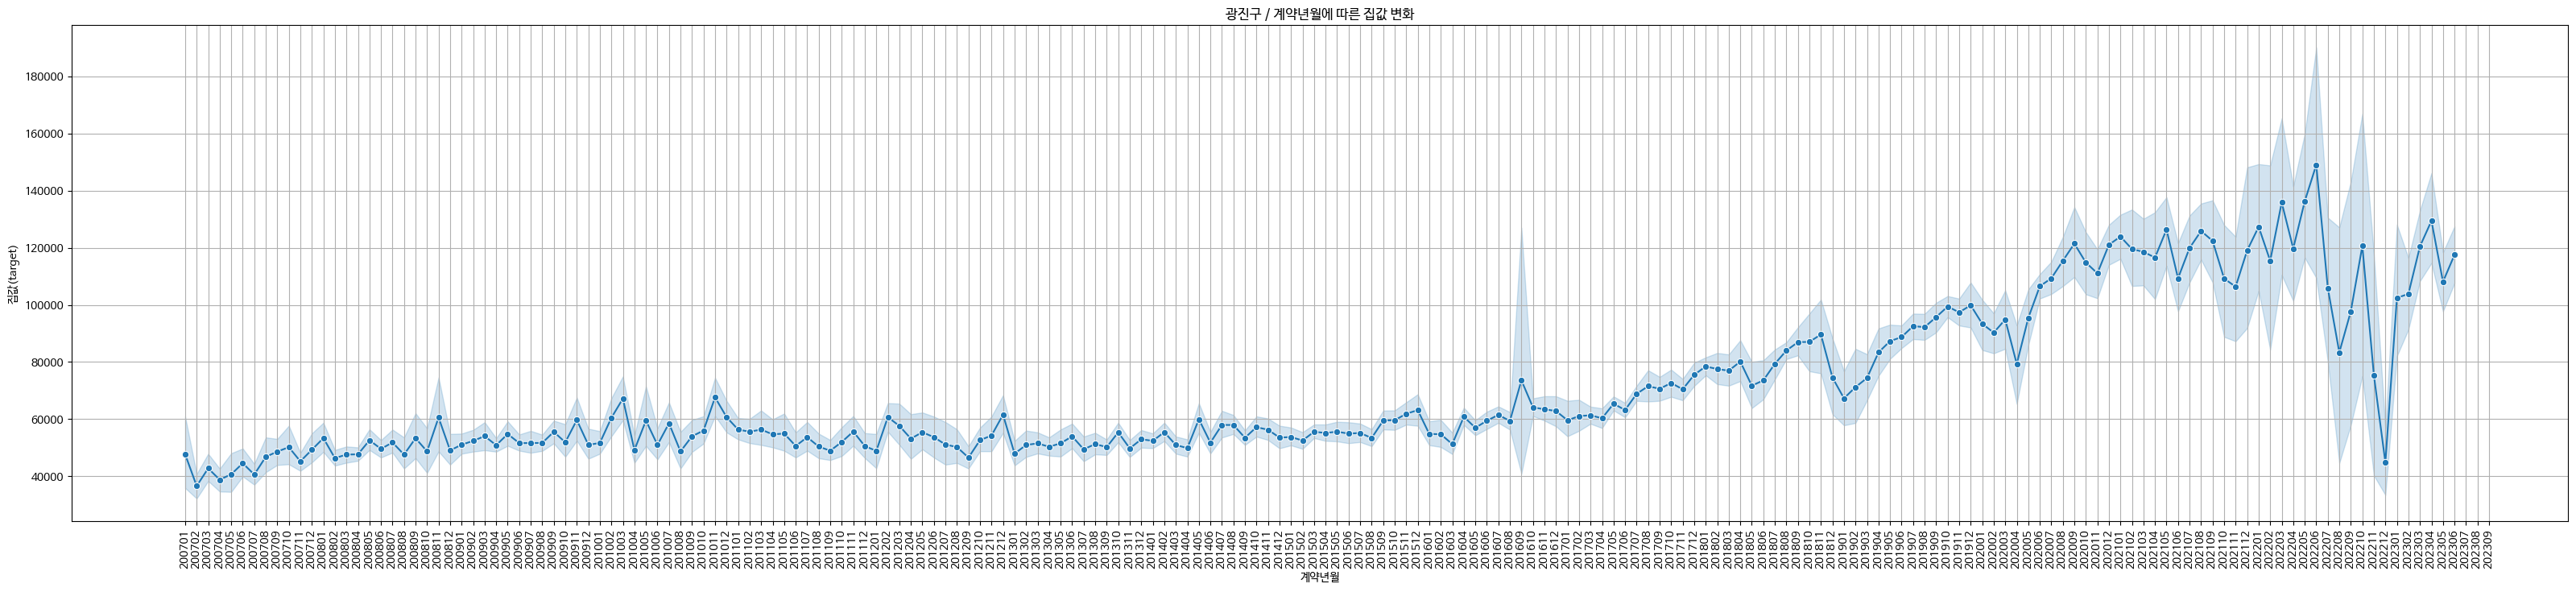

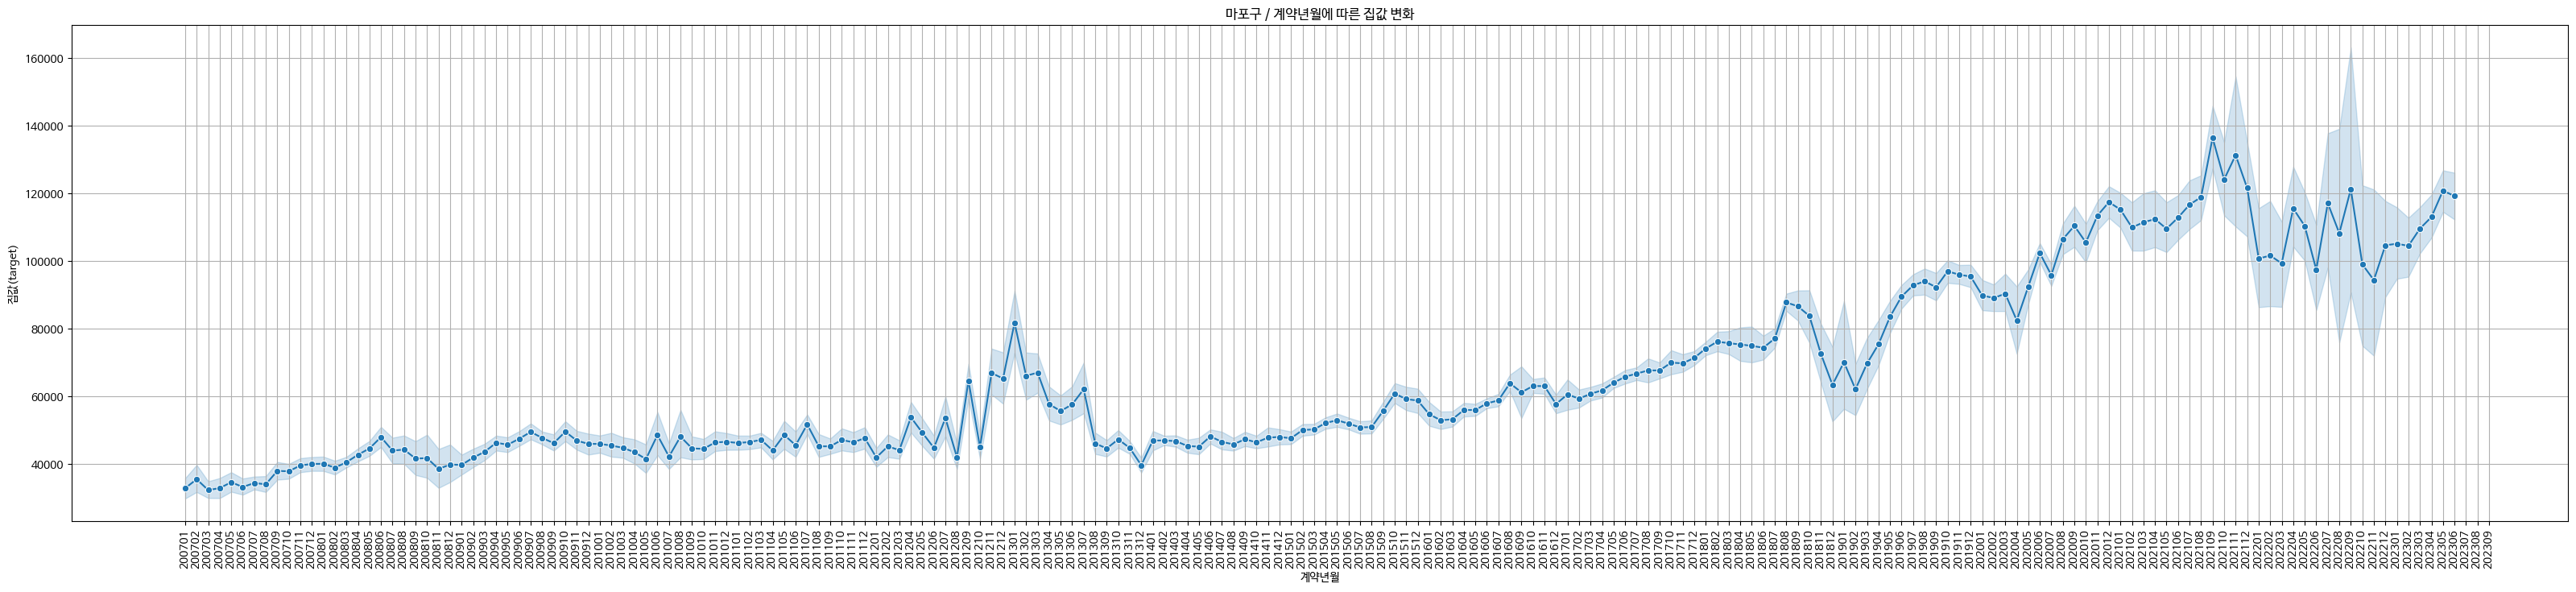

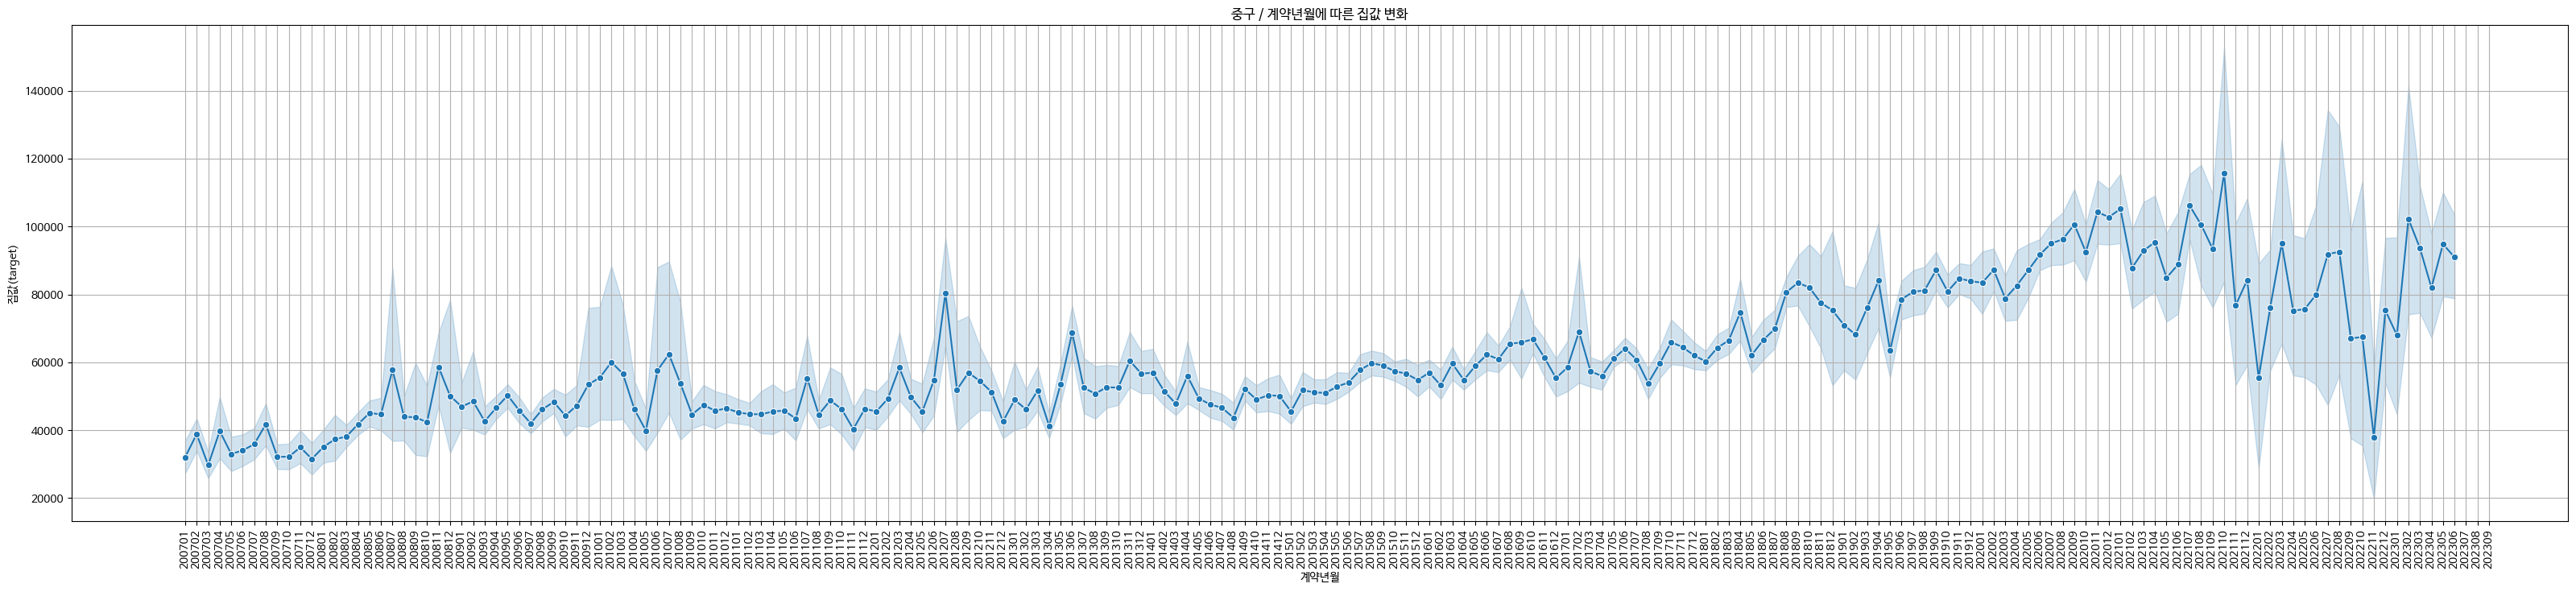

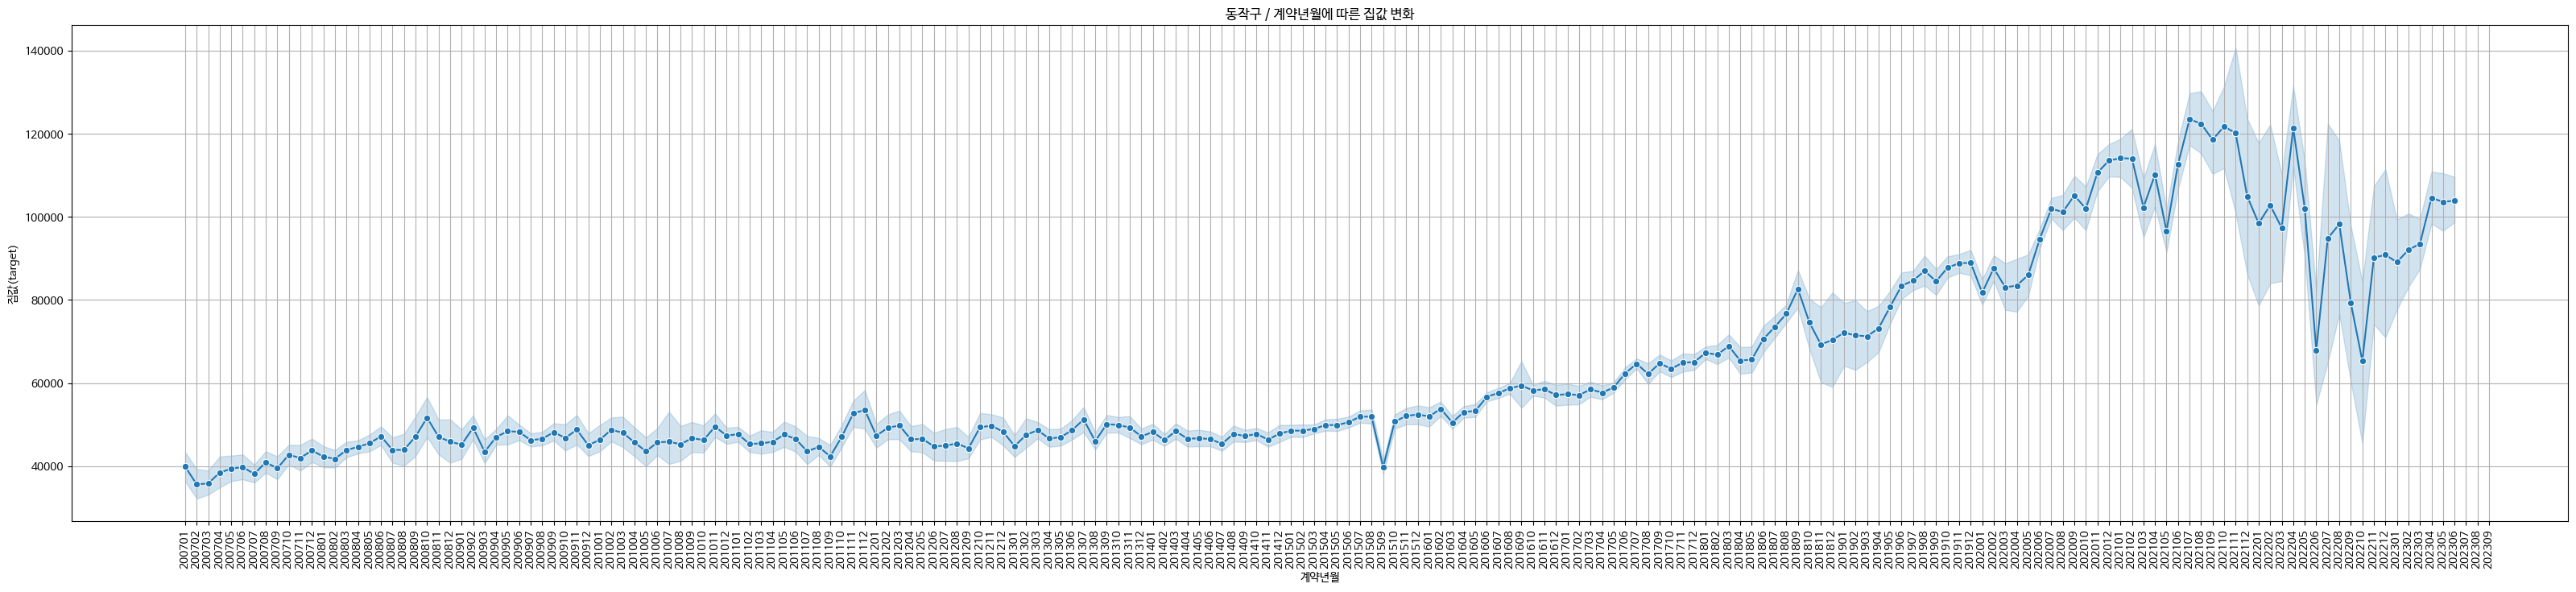

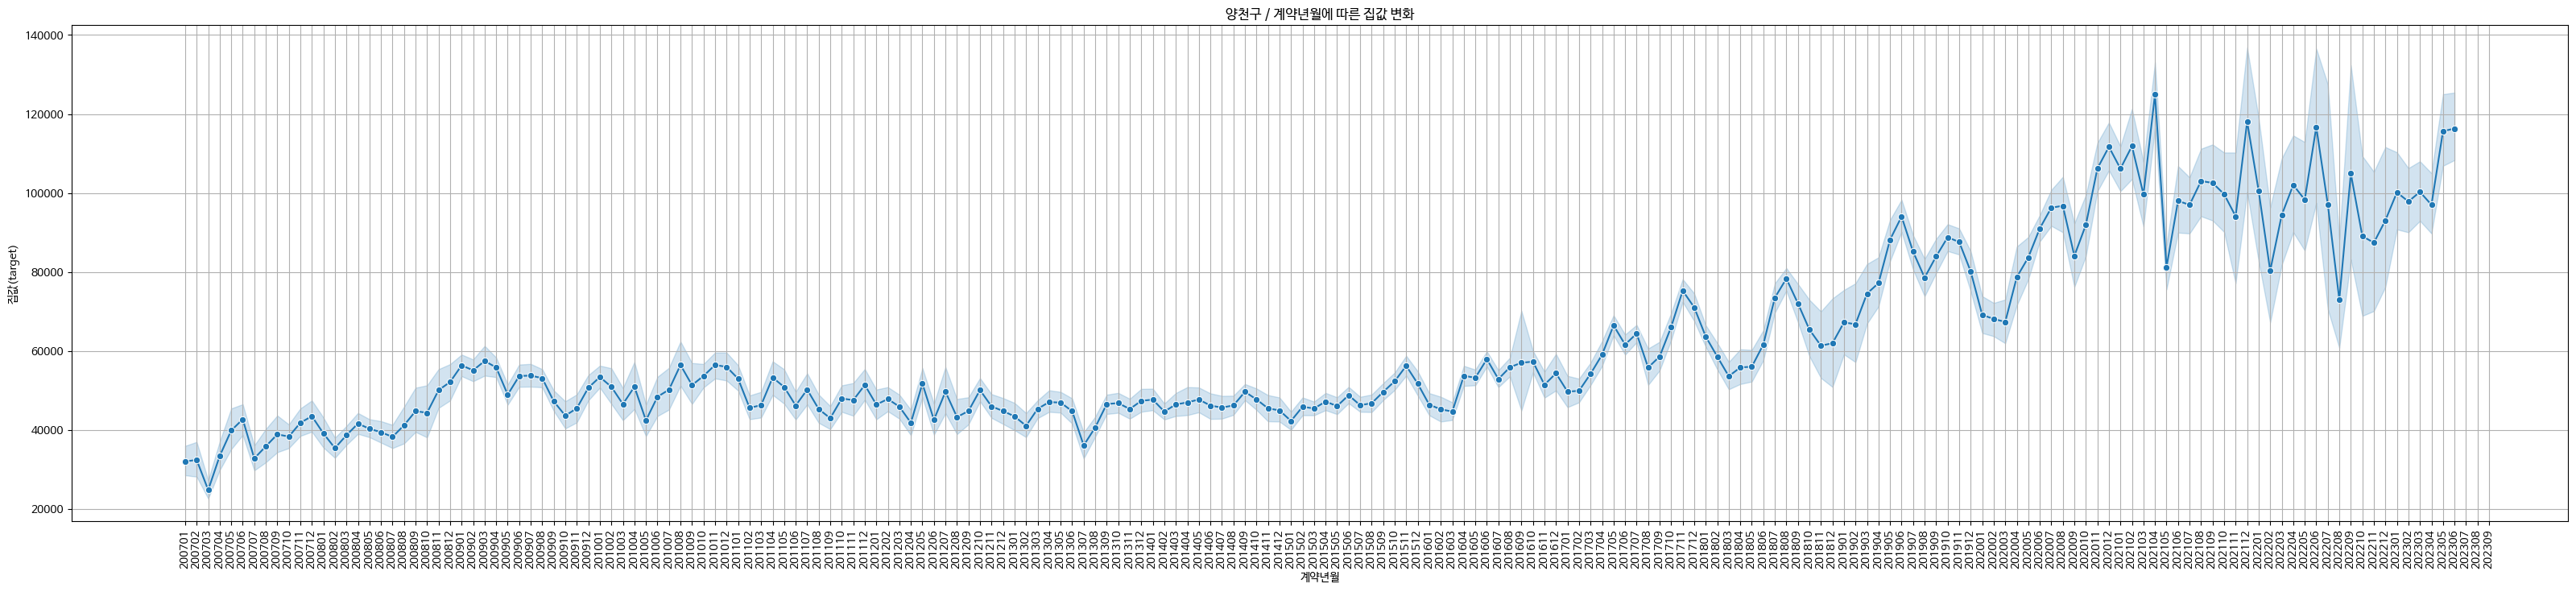

In [135]:
gu_list = visual.groupby("구").mean()[["집값(target)"]].sort_values(by=["집값(target)"], ascending=False).head(10).index
for gu in gu_list:
    plt.figure(figsize=(40, 8))
    plt.title(f"{gu} / 계약년월에 따른 집값 변화")
    plt.xticks(rotation=90)
    plt.grid(True)
    sns.lineplot(data = visual[visual["구"]==gu], x="계약년월", y= "집값(target)", marker='o')
    plt.show()

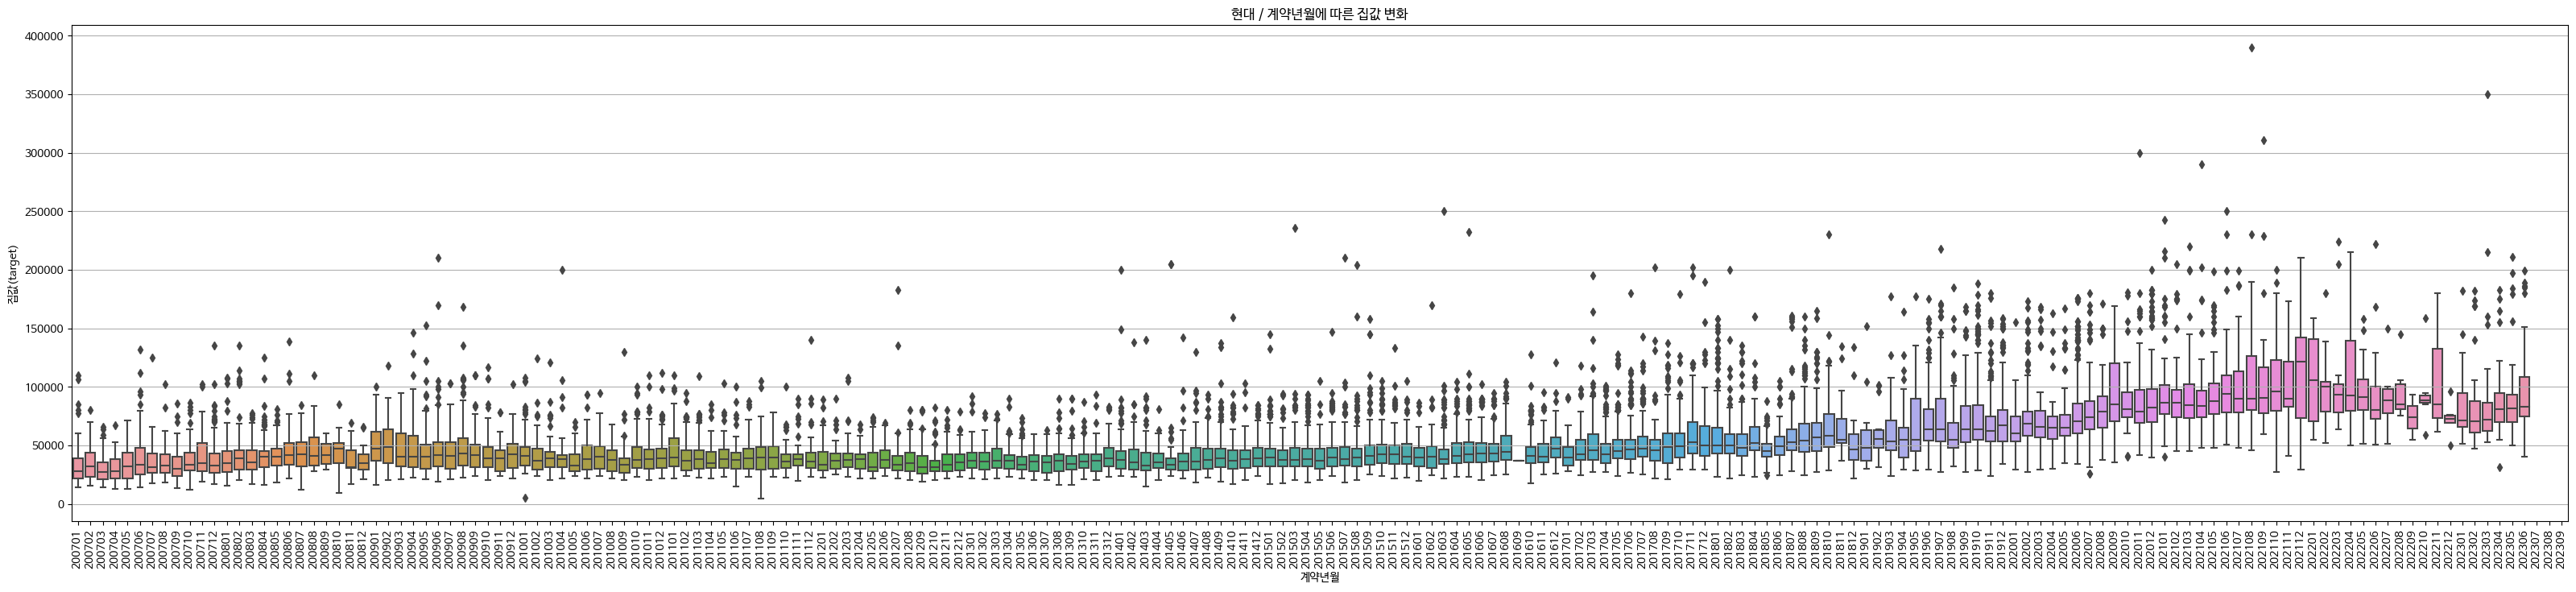

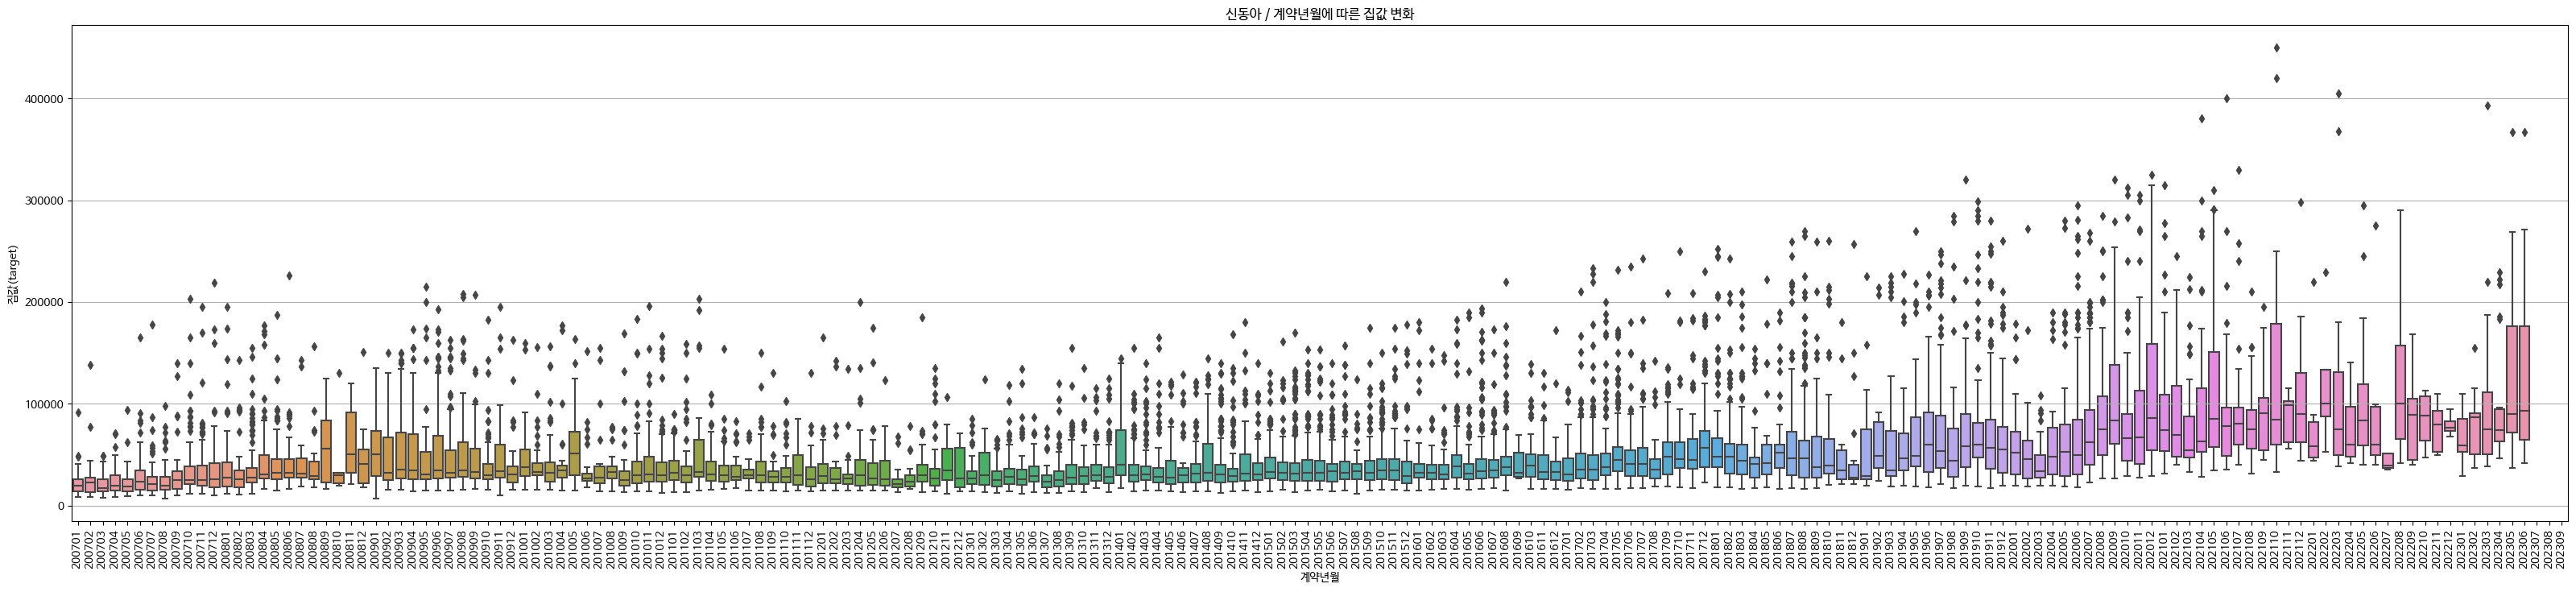

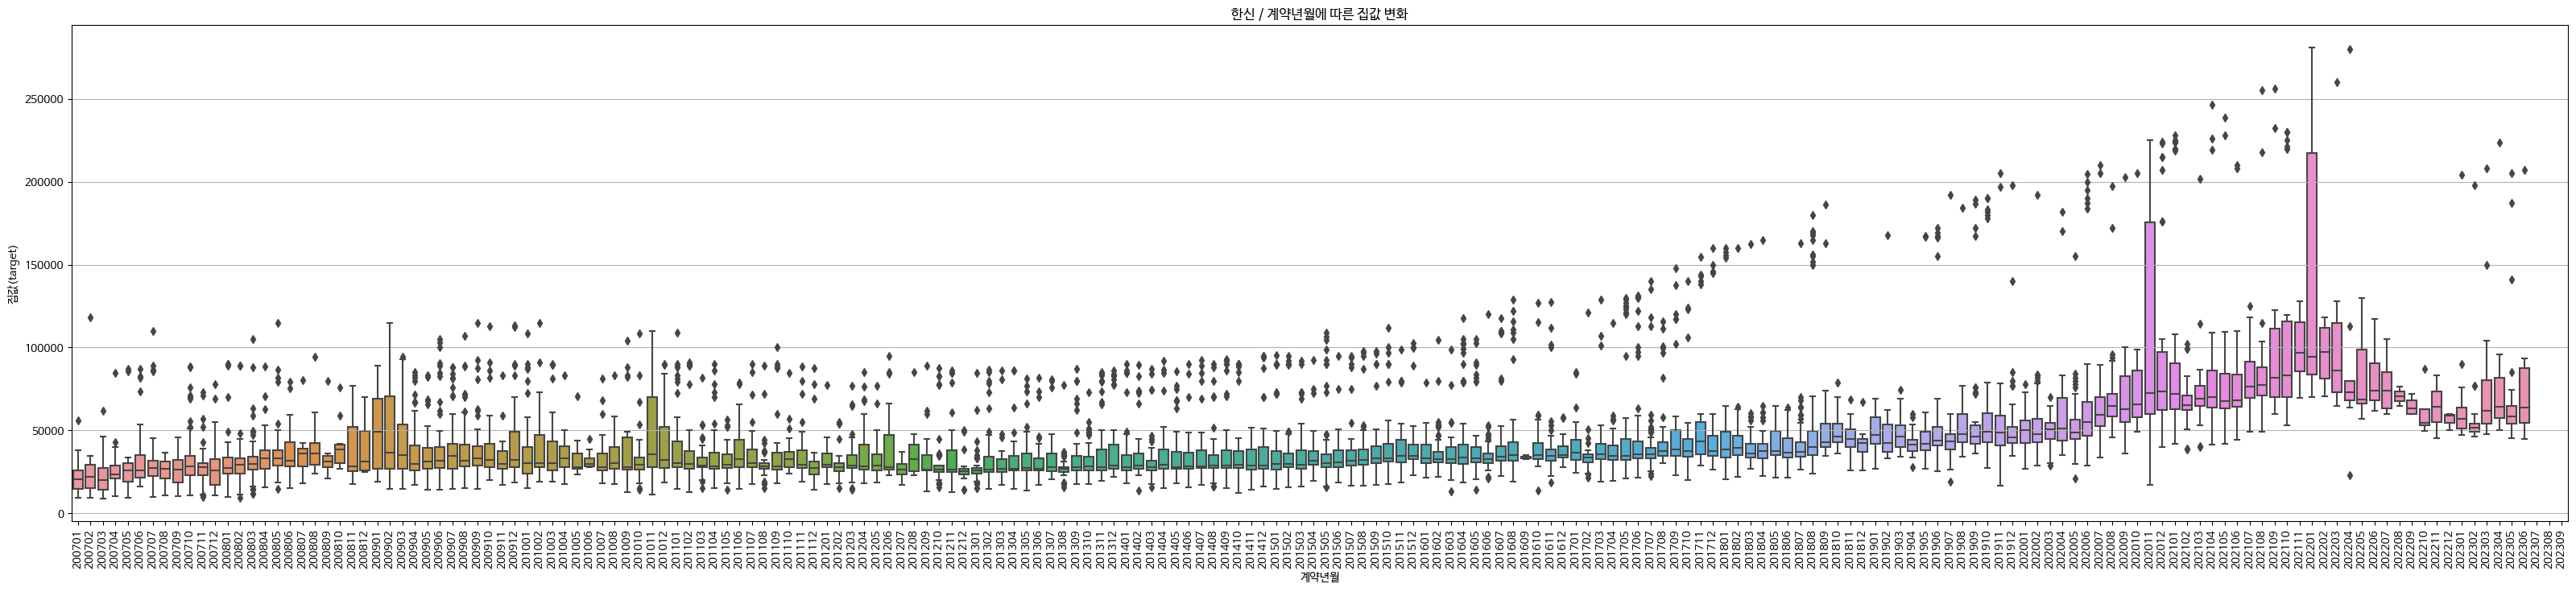

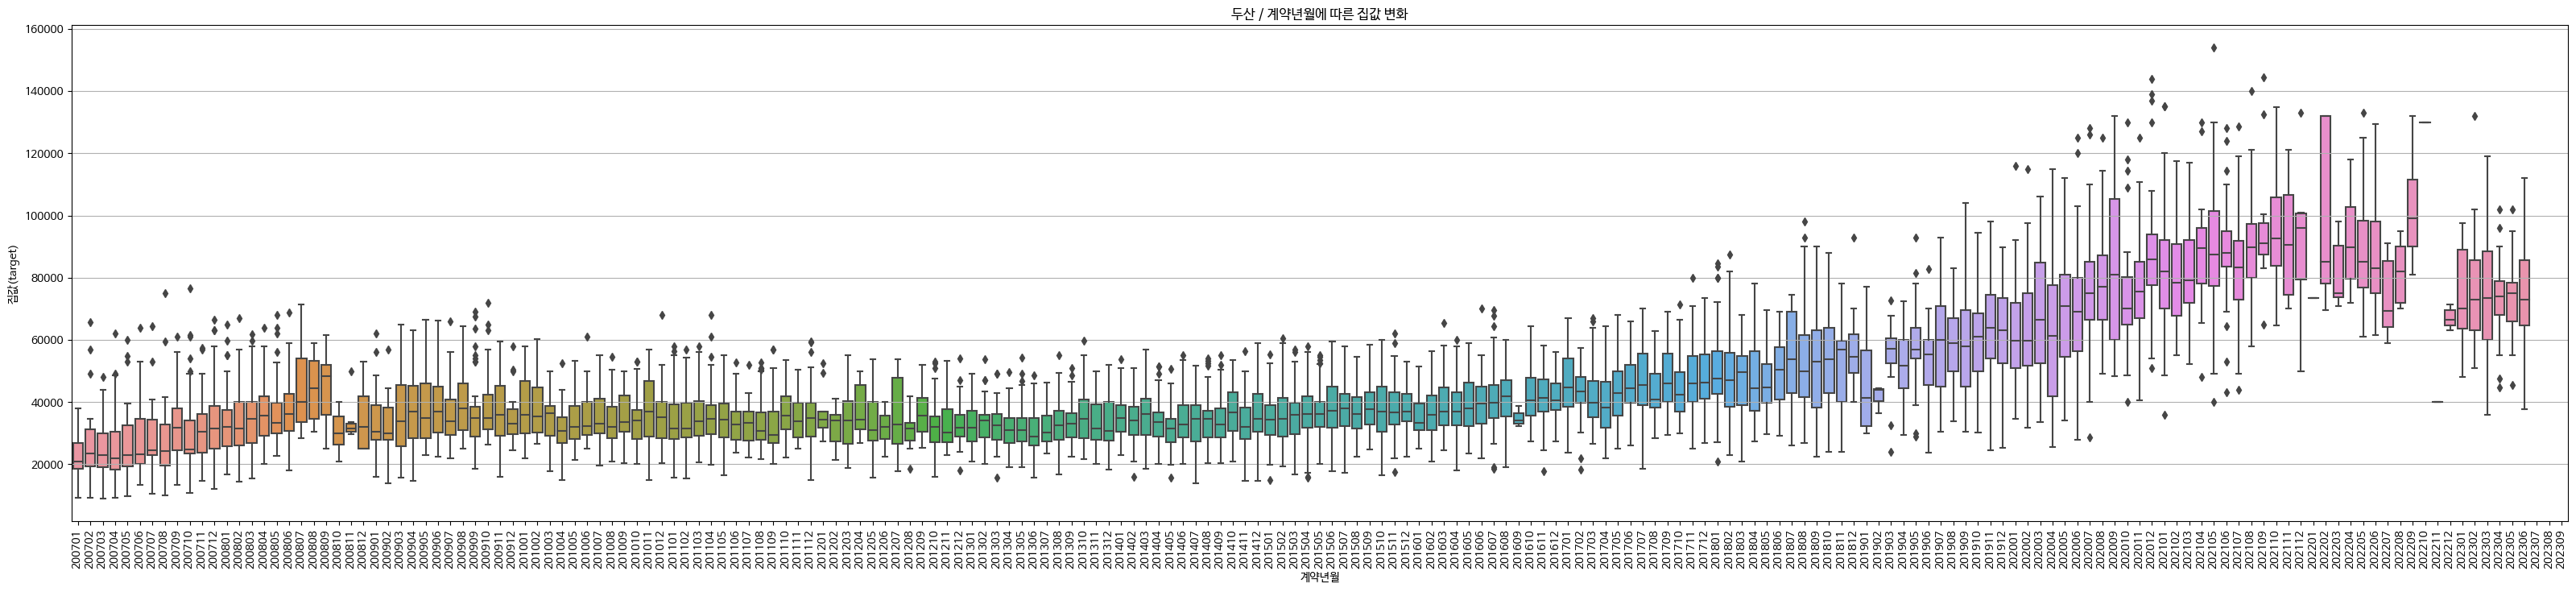

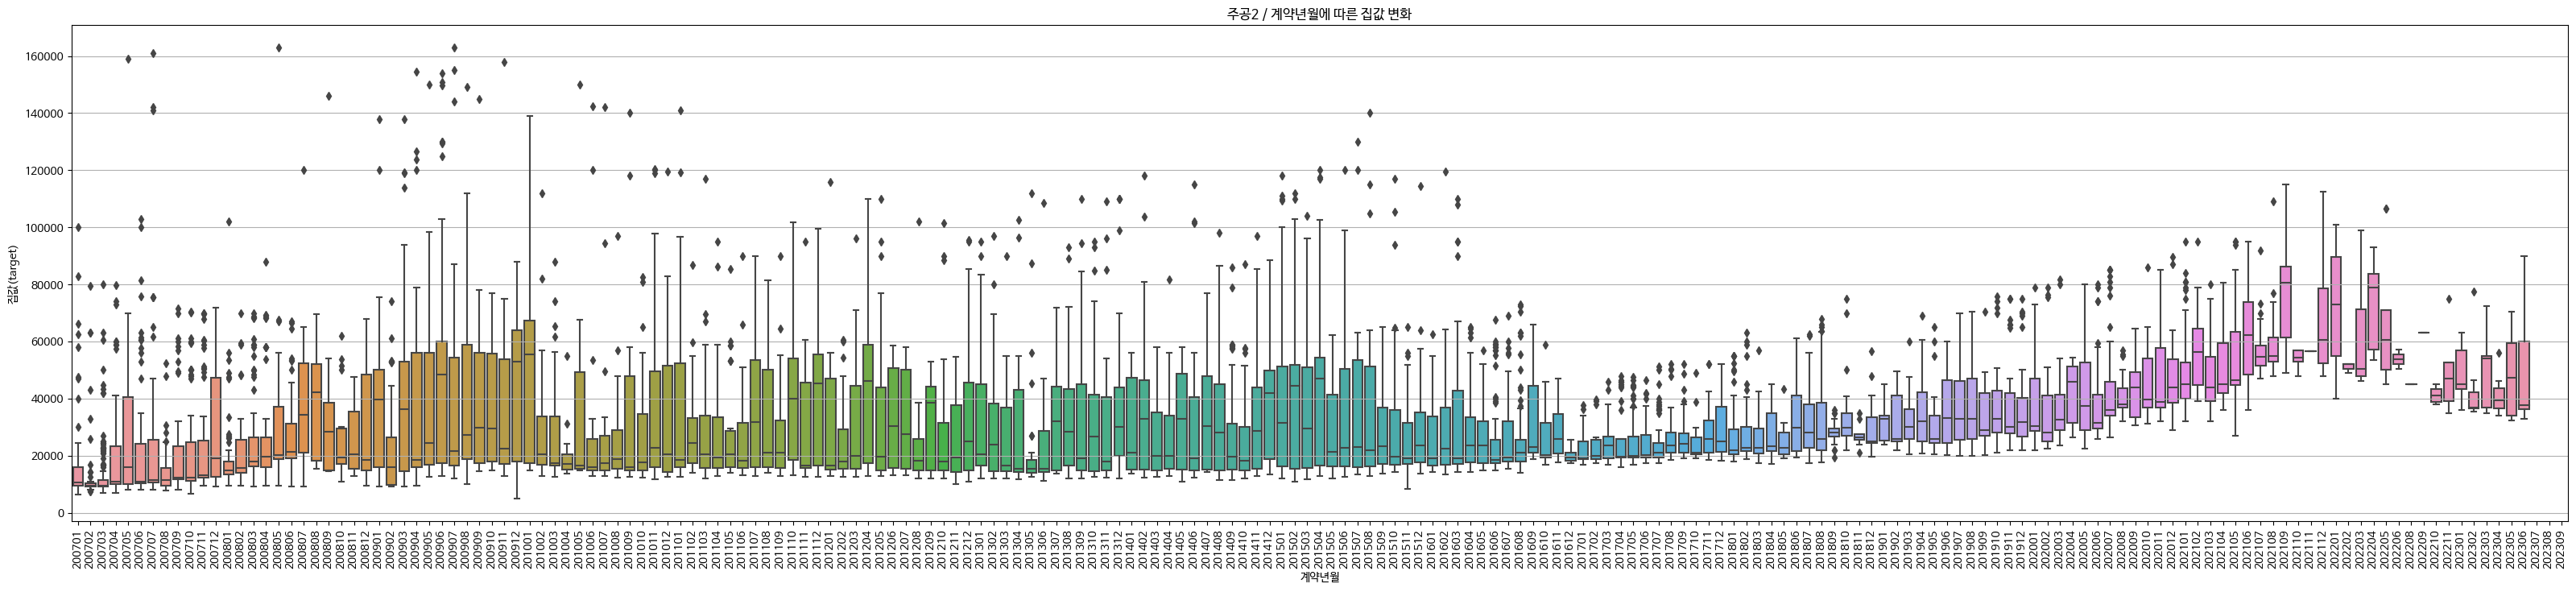

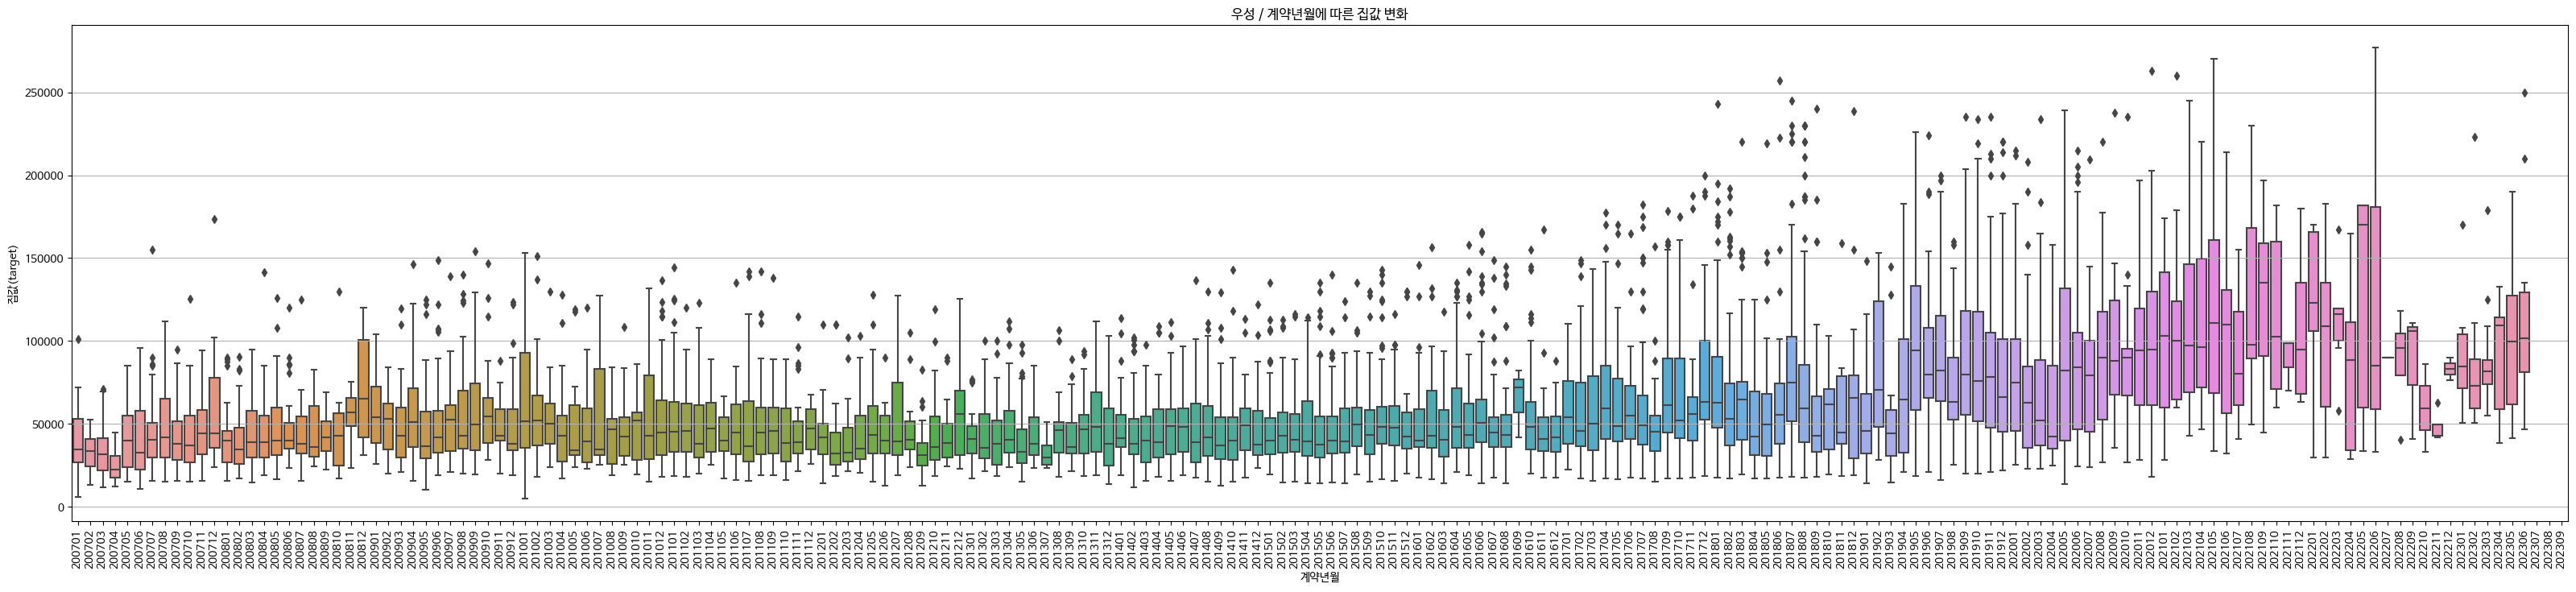

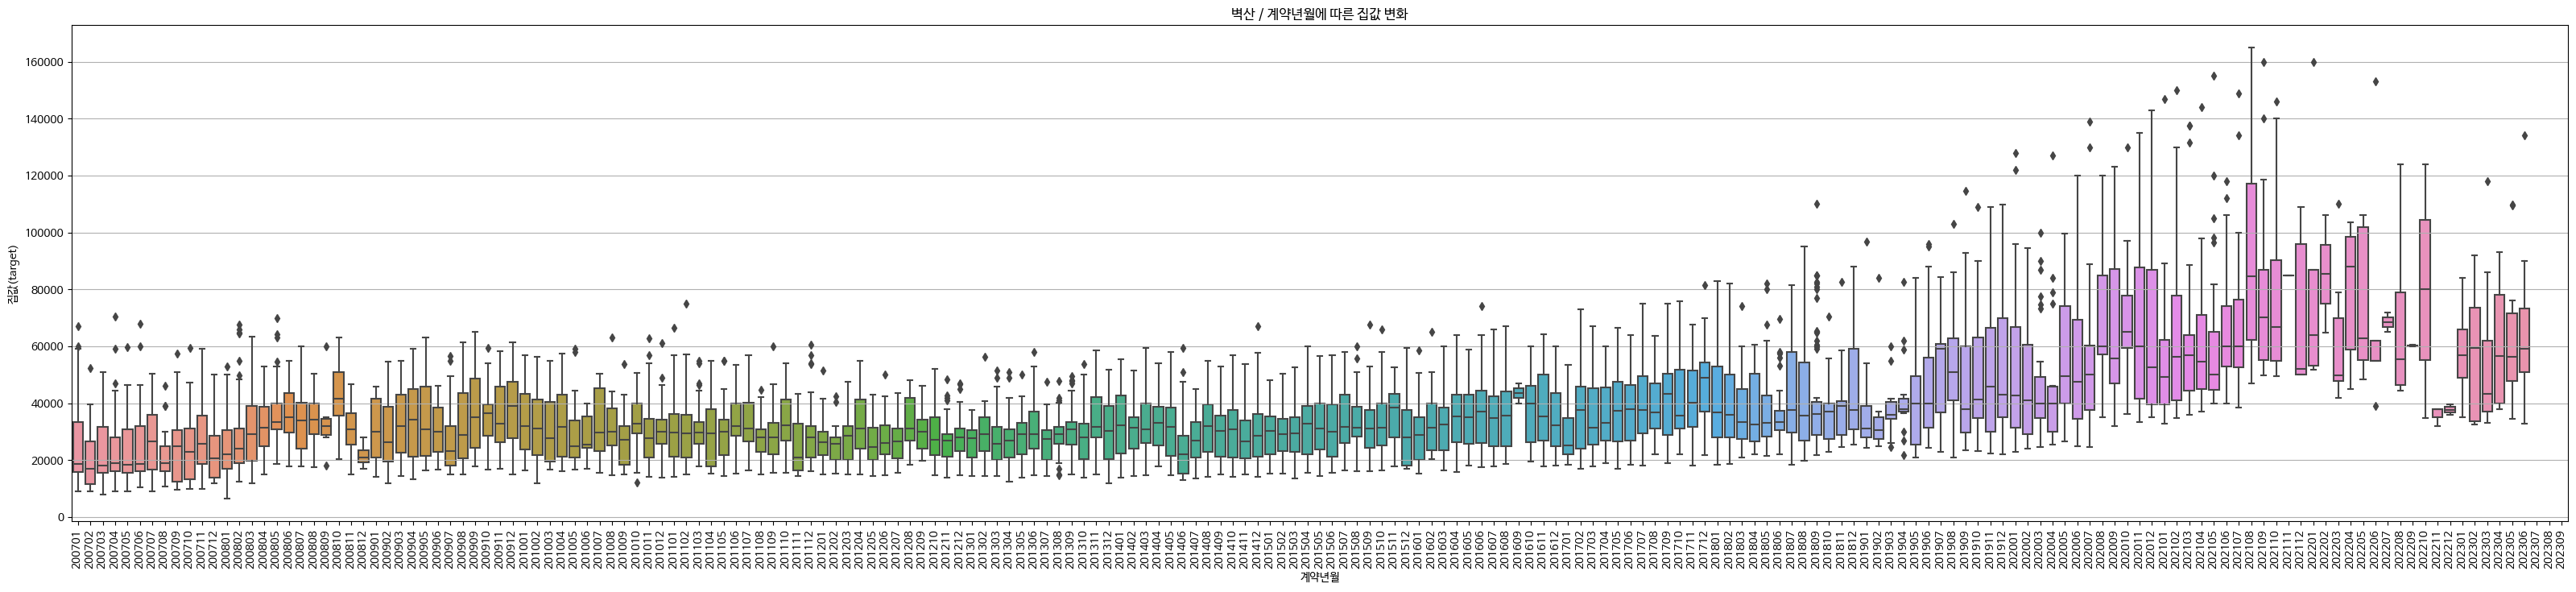

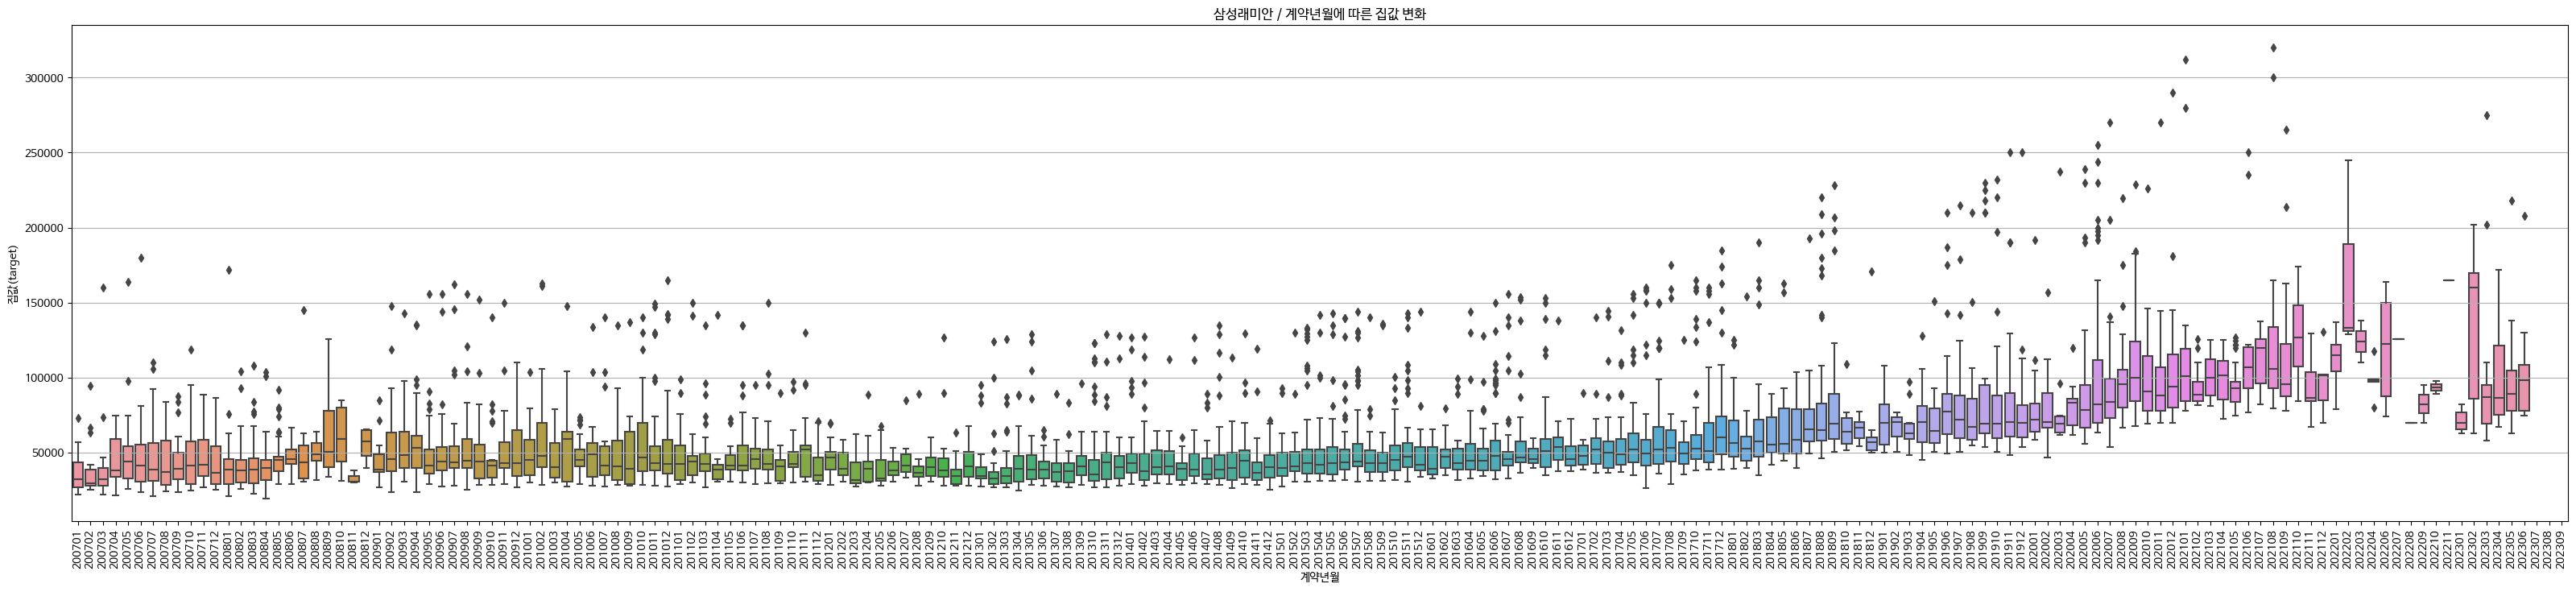

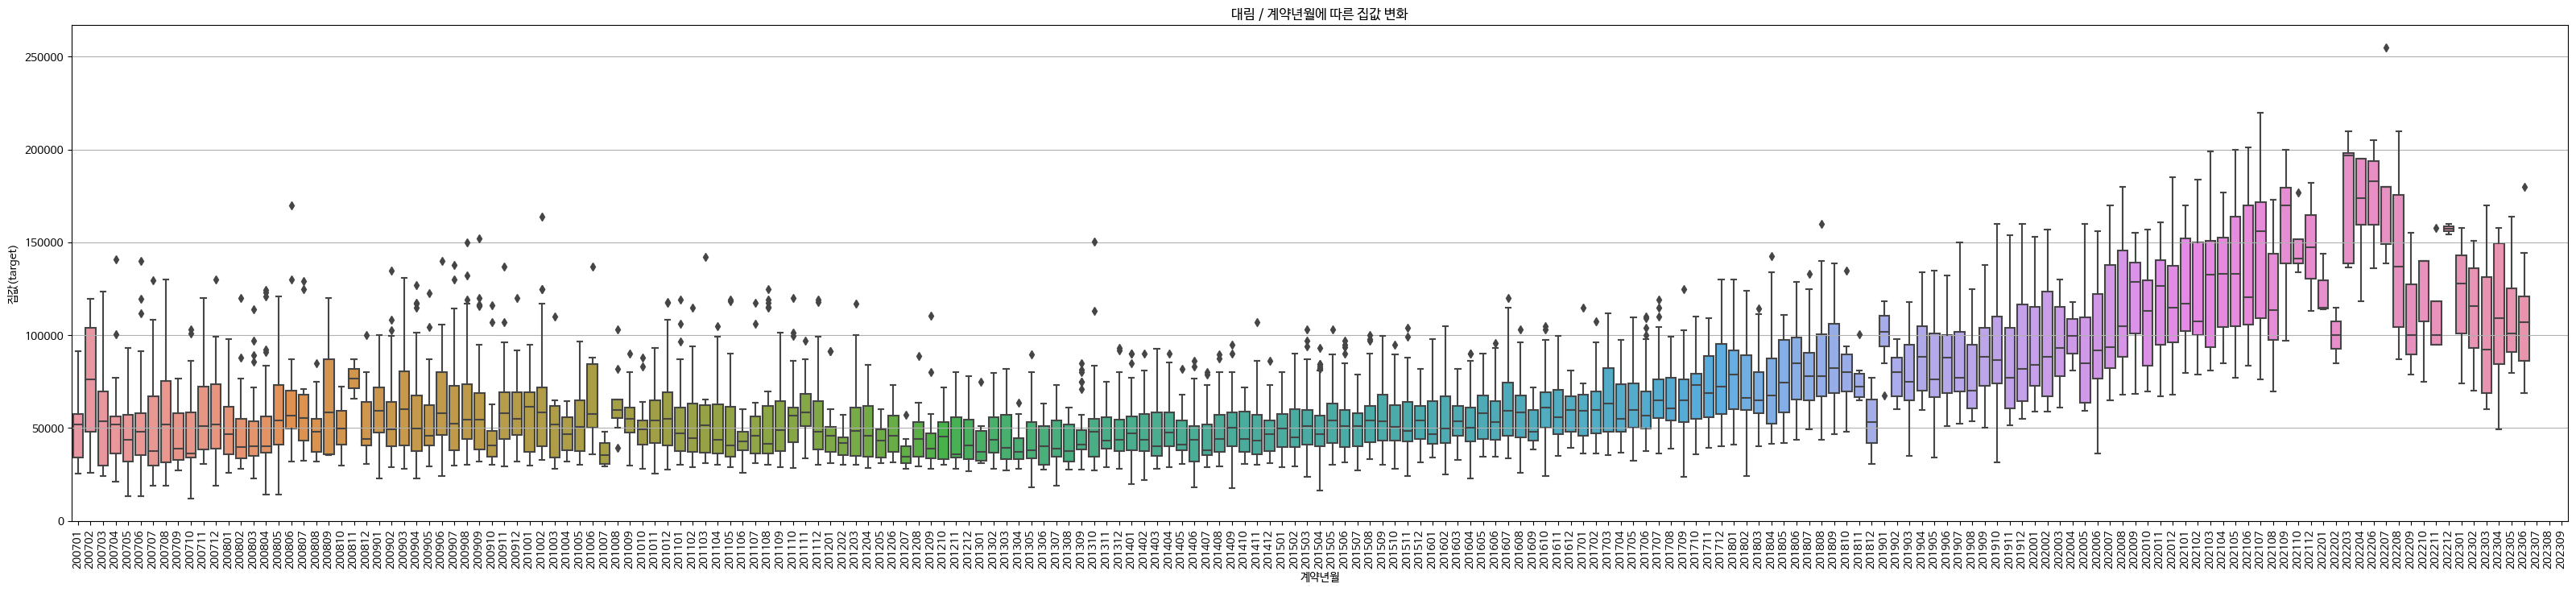

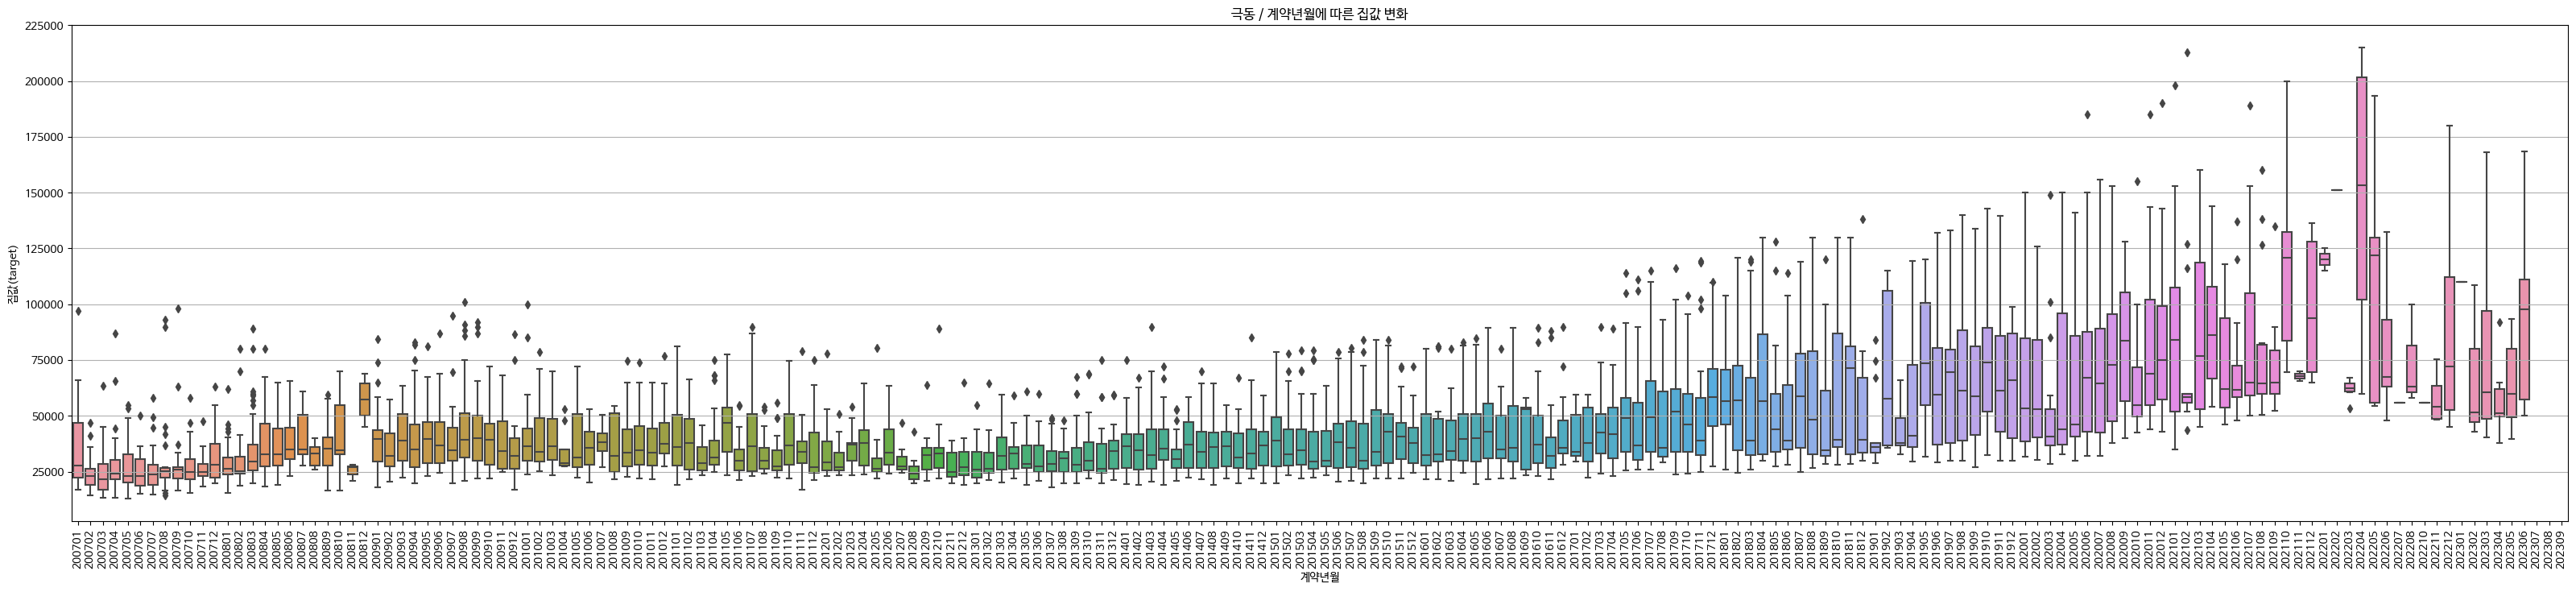

In [136]:
# 아파트 명
many_trade_top10 = visual.groupby(by="아파트명")["집값(target)"].count().sort_values(ascending=False).head(10).index

for name in many_trade_top10:
    plt.figure(figsize=(40, 8))
    plt.title(f"{name} / 계약년월에 따른 집값 변화")
    plt.xticks(rotation=90)
    plt.grid(True)
    sns.boxplot(data = visual[visual["아파트명"]==name], x="계약년월", y= "집값(target)")
    plt.show()

In [137]:
visual_mean_gu_top10 = visual.groupby("구").mean()[["집값(target)"]].sort_values(by=["집값(target)"], ascending=False).head(10)
display(visual_mean_gu_top10)
total_target_mean = visual["집값(target)"].mean()
print(total_target_mean)

집값(target)
구                 
강남구  114847.461503
서초구  113608.653390
용산구  105876.961900
송파구   83868.032920
성동구   68924.389400
광진구   67158.379293
마포구   64445.226137
중구    62084.985733
동작구   60936.451058
양천구   59042.132927

57991.532148992424


In [138]:
visual_mean_year = visual.groupby("계약년", as_index=False).mean()[["집값(target)"]].sort_values(by=["집값(target)"], ascending=False)
display(visual_mean_year)

집값(target)
16  105019.238660
14  103053.294826
15  100060.129278
13   84962.562901
12   82215.074716
11   65895.231486
10   61972.300582
9    53448.494413
2    50162.794165
3    49571.817532
8    47739.739964
7    45831.005509
4    45494.878488
5    44379.360554
6    44318.094953
1    39559.710447
0    31969.883574

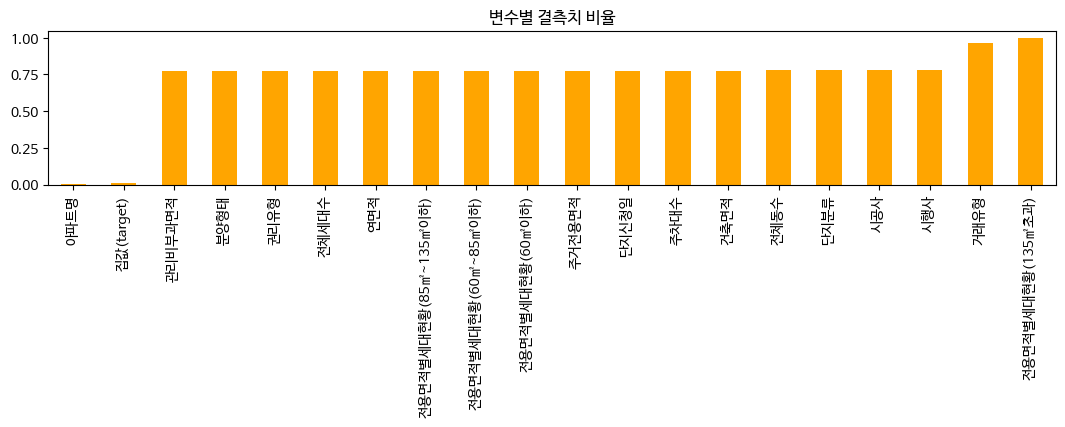

In [139]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing_ratio = using_concat.isnull().sum() / using_concat.shape[0]
missing_ratio = missing_ratio[missing_ratio > 0]
missing_ratio.sort_values(inplace=True)
missing_ratio.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [140]:
missing = using_concat.isnull().sum()
missing_index = missing[missing > 0].index
for index in missing_index:
    print(f"== {index} ==")
    print(using_concat[index].unique())

== 아파트명 ==
['개포6차우성' '개포우성3차' '개포자이' ... '히페리온리버팰리스' '세운푸르지오헤리시티' '힐스테이트세운센트럴1단지']
== 거래유형 ==
[nan '중개거래' '직거래']
== 단지분류 ==
['아파트' '주상복합' nan '연립주택' '도시형 생활주택(아파트)' '도시형 생활주택(주상복합)']
== 분양형태 ==
['분양' '기타' nan '임대']
== 전체동수 ==
[  8.   5.   4. 124.   6.   9.   1.  14.  nan  34.   2.  11.  28.  15.
   7.  12.  16.   3.  19.  10.  26.  20.  13.  22.  41.  40.  37.  21.
  50.  23.  18.  32.  24.  31.  17.  33.  51.  44.  30.  56.  72.  84.]
== 전체세대수 ==
[ 270.  405.  212. 5040.  940. 1060.  203.  260.  368.  960.  630.   83.
  354.  144.  372. 3002.  384.  390.  397.  768. 4424.   nan  132.   59.
  416.  298.  114.  546.  395.  410.  809.  912.  787.  498.  139.   86.
  464.  117. 1050.  408.  738.  294.  137.  364.  570.  716. 1304. 1020.
 1070.  391.  240.  888.  108.  708.  317.  694.  282.  442.  987.  722.
  553.  731.  841.  605.  740.  748.  636.  207.  800.  232.  772. 2283.
  687.  222.  151. 1622.  230.   74.  225.  999.  150.  615.  480. 1585.
  376.  216.  380.  261.  430. 1624. 

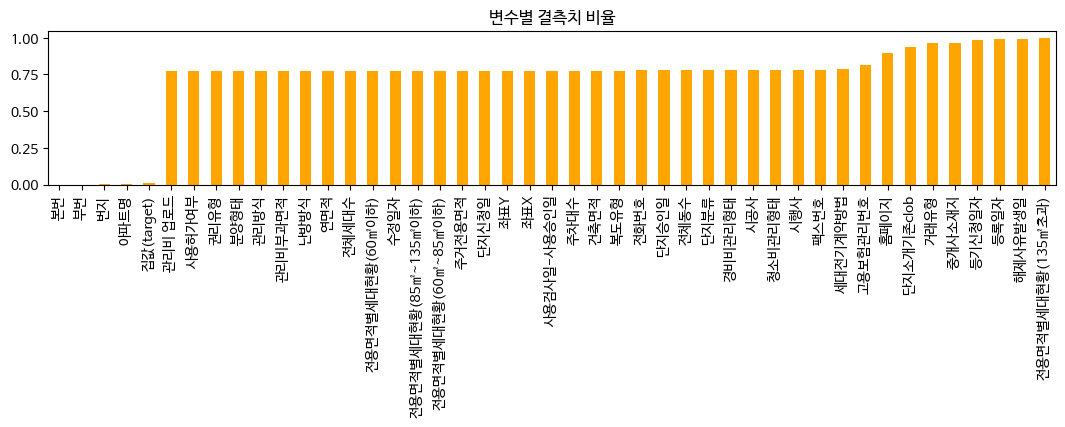

In [141]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing_ratio = concat.isnull().sum() / concat.shape[0]
missing_ratio = missing_ratio[missing_ratio > 0]
missing_ratio.sort_values(inplace=True)
missing_ratio.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

## Variance

1. 시군구
2. 번지
3. 본번 : 도로명 주소에서 00-00 에서 앞부분
4. 부번 : 도로명 주소에서 00-00 에서 뒷부분
5. 아파트명 
6. 전용면적 : 각 세대가 독립적으로 사용하는 전용 공간
7. 계약년월
8. 계약일
9. 층
10. 건축년도
11. 도로명 : 도로명 길번호
12. 해제사유발생일 : 부동산 거래에서 계약이나 조건이 해제되거나 종료되는 날짜를 나타냅니다. 이 날짜는 일반적으로 계약 조건에 따라 정해지며, 거래의 어떤 이유로 인해 계약이 종료되거나 해제되는 경우에 발생
13. 등기신청일자 : 부동산 거래와 관련하여 해당 부동산의 소유자 또는 권리자가 등기청에 소유권 이전이나 다른 부동산 권리에 대한 등기를 신청한 날짜를 의미
14. 거래유형 : 중개거래, 직거래 (대부분 Nan값)
15. 중개사소재지 : 공인중개사 소재지 (특이한 점으로 제주, 경기 등 서울이 아닌 곳도 존재)
16. k-단지분류(아파트,주상복합등등) : ['아파트', '주상복합', nan, '연립주택', '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)']
17. k-전화번호
18. k-팩스번호
19. 단지소개기존clob : ??
20. k-세대타입(분양형태) : ['분양', '기타', nan, '임대'], 분양은 사실상 아파트 매매
21. k-관리방식 :['자치관리', '위탁관리', '직영', nan] 자치관리는 입주자들이 직접 관리자 선출, 위탁관리는 관리업체를 통해 관리, 직영은... 뭔데???
22. k-복도유형 : ['계단식', '혼합식', '복도식', '타워형', '기타', nan]
23. k-난방방식 : ['개별난방', '지역난방', '기타', nan, '중앙난방'] 지역난방: 대규모 열생산시설에서 만들어진 열을 지역에 공급
24. k-전체동수
25. k-전체세대수
26. k-건설사(시공사) : 실제로 건설을 하는 회사(건설 의뢰를 맡은 회사)
27. k-시행사 : 건설을 주관하는 회사(건설 의뢰를 맡긴 회사)
28. k-사용검사일-사용승인일
29. k-전용면적별세대현황(60㎡~85㎡이하)
30. k-85㎡~135㎡이하
31. k-135㎡초과
32. k-홈페이지
33. 건축면적 : 대지에서 건축물이 차지하고 있는 면적을 말한다.
34. 주차대수
35. 기타/의무/임대/임의=1/2/3/4 : 이게 뭔데?  
GPT 산 답변  
기타 (Other): "기타"는 주로 다른 명시된 범주에 해당하지 않는 다양한 부동산 유형이나 거래 유형을 나타냅니다. 예를 들어, 특정 분류에 정확하게 포함되지 않는 특별한 부동산 유형을 지칭할 때 사용될 수 있습니다.  
의무 (Encumbrance): "의무"는 부동산에 대한 부담, 제약, 혹은 제약사항을 나타냅니다. 예를 들어, 저당권, 전세권, 가압류, 귀속조서 등이 부동산에 부과되는 제약사항으로 간주될 수 있습니다.  
임대 (Lease): "임대"는 부동산을 임대하거나 빌릴 때 사용되는 용어입니다. 부동산 소유자는 일정 기간 동안 임차인에게 부동산 사용을 허용하고, 그 대가로 임차인은 임대료를 지불합니다.  
임의 (Arbitrary): "임의"는 주로 부동산에 대한 임의의 권리나 조건을 나타내는데 사용됩니다. 이 용어는 특별한 상황에 따라 다르게 해석될 수 있습니다. 일반적으로 부동산 거래나 계약에서 자유롭게 조정 가능한 부분을 나타낼 때 사용될 수 있습니다.  
36. 단지승인일
37. 사용허가여부
38. 관리비 업로드
39. 좌표X
40. 좌표Y
41. 단지신청일


집 값에 직접적 영향이 갈 Variable : 시군구, 아파트명, 전용면적, 계약년월, 계약일, 층, 건축년도, 도로명, 거래유형, k-단지분류, k-세대타입, k-전체동수, k-전체세대수, k-건설사(시공사), k-시행사, k-전용면적별세대현황(60㎡~85㎡이하), k-85㎡~135㎡이하, k-135㎡초과, 건축면적, 주차대수

## EDA

- 집 수(?) 자체는 노원구가 많음, 근데 전용면적은 상대적으로 작음, 또한 가격도 하위에 있음
- 집 값 자체는 강남구, 서초구, 용산구가 높음 또한 서초구, 용산구는 다른 곳에 비해 평균 전용면적이 높다.(서초구, 용산구의 집들은 전용 면적이 영향을 주었을 것이라 예상) 
강남구는 다른 곳과 비슷 (강남구는 다른 곳보다 평균 가격이 높으면서도 전용면적은 비슷하다 이는 강남구에서는 다른 요인이 집값을 결정하고 있다는 것을 알 수 있음)

- 전용면적이 넓으면 비쌀것이다.
- 건축년도가 최근이면 비쌀 것이다
    - 건축년도가 개같이 다양함... -> 년대별로 묶어서 할 수 있지 않을까?
    - 년대별이라고 하니 뉴스기사에서 나오는 평균 집값은 어떻게 집계했지?, 년도별 기준금리에 따라서도 집값 등락이 결정 될 것 같은데...
- 특정 구, 동이면 비쌀 것이다.
    - 강남구, 서초구, 용산구가 특히 높음 왜? -> 전용면적 확인 해보자 => 서초구, 용산구는 다른 곳에 비해 평균 전용면적이 높다. 강남구는 다른 곳과 비슷 = 강남구는 다른 곳보다 평균 가격이 높으면서도 전용면적은 비슷하다 이는 강남구에서는 다른 요인이 집값을 결정하고 있다는 것을 알 수 있음
- 거래 유형이 영향을 주나?
- 기타, 의무, 임대, 임의는 뭘 의미하지?
- 좌표가 있으니 주변 풍경 여부(예시로 한강뷰, 한강 근처, 대학교 여부, 유명회사 여부 등)를 알 수 있지 않을까?
- 도로명이 있으니 주변 시설여부도 알 수 있지 않을까? (위와 같은 맥락)
- 전체 세대수가 영향을 줄까?(인기가 많으면 가격이 올라가니까 전체 세대 수가 상대적으로 높지 않을까?)
- 시공사 및 시행사가 영향이 있을까?(유명한 시공사, 시행사이면 가격이 상대적으로 높지 않을까?)

- 전용 면적, 주거전용면적, 관리비부과면적, 연면적 등 면적에 관련된 변수들의 의미를 알아야함..